## Covid19 Analysis & Forecast
#### by Khairul Omar
https://github.com/khairulomar/Covid-19<br>
https://www.linkedin.com/in/khairulomar/

### 1. Import and clean data

In [1]:
# Latest available Actuals
day = 10
month = 4

# Import libraries
import pandas as pd
pd.options.display.max_rows = 200
import numpy as np
import math
import json
import requests
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")

In [2]:
allcols = ['date','updated', 'country', 'state', 'confirmed', 'deaths', 'recovered', 'new_confirmed', 'new_deaths', 'new_recovered']

In [ ]:
# # Multiple downloads from John Hopkins Hospital database
# start  = pd.to_datetime(f'20200122', format='%Y%m%d')
# oneday = pd.Timedelta(1, unit='days')
# end    = pd.to_datetime(f'20200315', format='%Y%m%d')
# for d in range((end - start).days+1):
#     date = start + oneday * d
#     day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
#     url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
#     df = pd.read_csv(url)
#     df.to_csv(f'csv/{month}-{day}-{year}.csv')

In [ ]:
# One-day download from John Hopkins Hospital database
date  = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
day0, month0, year0 = str(date)[8:10], str(date)[5:7], str(date)[:4]
url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month0}-{day0}-{year0}.csv'
zero = 0 if day < 10 else ''
df = pd.read_csv(url)
df.to_csv(f'csv2/0{month}-{zero}{day}-2020.csv')

In [ ]:
# Download Oxford global govt response tracker
# https://www.bsg.ox.ac.uk/research/research-projects/oxford-covid-19-government-response-tracker
oxford = pd.read_csv('https://ocgptweb.azurewebsites.net/CSVDownload')
oxford.to_csv('csv2/govt_tracker_raw.csv')

In [ ]:
# Clean up Oxford table
oxford = pd.read_csv('csv2/govt_tracker_raw.csv')
oxcols = {'CountryName':'country', 'Date':'date', 'S1_School closing':'school', 'S2_Workplace closing': 'workplace',
          'S3_Cancel public events':'events', 'S4_Close public transport':'transport', 'S5_Public information campaigns':'campaigns',
          'S6_Restrictions on internal movement':'movement', 'S7_International travel controls':'immigration',
          'S8_Fiscal measures':'fiscal', 'S9_Monetary measures':'monetary', 'S10_Emergency investment in health care':'healthcare',
          'S11_Investment in Vaccines':'vaccines', 'S12_Testing framework':'testing', 'S13_Contact tracing':'tracing',
          'StringencyIndex':'stringency'}
oxford = oxford.rename(columns=oxcols)
oxford = oxford[oxcols.values()]
cols = [col for col in list(oxford.columns) if col not in ['country', 'fiscal', 'healthcare', 'vaccines']]
for col in cols: oxford[col] = oxford[col].fillna(method='ffill')
oxford.fiscal = oxford.fiscal.replace(0, np.nan)
oxford.healthcare = oxford.healthcare.replace(0, np.nan)
oxford.to_csv('csv2/govt_tracker.csv')

In [ ]:
# Process files with formatting prior to 23/03/2020
path = 'csv/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country/region':'country'})
        df0 = df0.rename(columns={'province/state':'state'})
        df0 = df0.rename(columns={'last update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        df0['fips'] = 0
        for col in ['confirmed','deaths','recovered']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df01 = df.copy()
        
# Process files with formatting from 23/03/2020
path = 'csv2/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('2020.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country_region':'country'})
        df0 = df0.rename(columns={'province_state':'state'})
        df0 = df0.rename(columns={'last_update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered','fips','admin2']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        for col in ['confirmed','deaths','recovered', 'fips']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df02 = df.copy()
    
# Append data from Hubei prior to 22/01/2020
raw = pd.read_csv('csv/older/pre_01-22-2020.csv')
prior = pd.DataFrame(columns=df0.columns)
for col in ['confirmed', 'country', 'deaths', 'recovered', 'state', 'updated']:
    prior[col] = raw[col]
for col in ['confirmed', 'deaths', 'recovered']:
    prior[col] = prior[col].astype(int)
prior.state = 'Hubei'
prior.country = 'Mainland China'
prior.fips = 0
prior.updated = pd.to_datetime(prior.updated, format='%d/%m/%Y')
prior.date = prior.updated

df = pd.concat([df02, df01, prior]).reset_index()
df0 = df.copy()

In [ ]:
df = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df.country = df.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df['temp'] = ''
for i in range(len(df)):
    state = df.iloc[i].state
    country = df.iloc[i].country
    if state in ['Channel Islands', 'Gibraltar', 'Cayman Islands',
                 'Faroe Islands']:
        df.iloc[i, df.columns.get_loc('country')] = df.iloc[i, df.columns.get_loc('state')]
    elif (state == country) | (state == 'None') | (state == 'UK'):
        df.iloc[i, df.columns.get_loc('state')] = country
    elif state.find('Princess') > 0:
        if country != 'Cruise Ship':
            df.iloc[i, df.columns.get_loc('state')] = f'Cruise {country}'
        else:
            df.iloc[i, df.columns.get_loc('state')] = 'Cruise Ship'
    elif country == 'United States':
        if state == 'Washington, D.C.':
            s = 'District of Columbia'
        elif state == 'US':
            s = 'Unassigned'
        elif state == 'Chicago':
            s = 'Illinois'
        elif (state == "Virgin Islands, U.S.") | (state == "United States Virgin Islands"):
            s = 'Virgin Islands'
        elif state.find(', ') > 0:
            s0 = state[state.find(', ')+2:state.find(', ')+4]
            s = geo['us_states'][s0]
        elif state in list(geo['us_states'].keys()):
            s = geo['us_states'][state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
    elif country == 'Canada':
        if state.find('Princess') > 0:
            s = 'Cruise Ship'               
        elif state.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s

df['state'] = df.apply(lambda row: row['temp'] if row['temp']!='' else (row['state'] if row['state']!='' else row['country']), axis=1)
df.country = df.apply(lambda row: row.state if (row.state=='Hong Kong')|(row.state=='Macau') else row.country, axis=1)
df.drop('temp', axis=1, inplace=True)

df = pd.pivot_table(df, values=['confirmed','deaths','recovered'], index=['date','updated','country','state'], columns=None, aggfunc='sum')
df = df.rename(columns={'confirmed':'confirmed_raw'})
df = df.reset_index()
dftemp = pd.DataFrame()
for state in df.state.unique():
    dfstate = df[df.state==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    dfstate['confirmed'] = dfstate.confirmed_raw
    # Replace raw with average between 2 dates due to incomplete data due to cut-off reporting time
    # e.g. if new cases suddenly drop by 90% in one day, most likely it's due to incomplete data
    for i in range(1,len(dfstate.index)-1):
        ratio = 1/2 # smoothing average ratio
        if dfstate.iloc[i+1].confirmed_raw / dfstate.iloc[i].confirmed_raw > 0.9:
            dfstate.iloc[i, dfstate.columns.get_loc('confirmed')] = int(dfstate.iloc[i+1].confirmed_raw * ratio
                                                                        + dfstate.iloc[i-1].confirmed_raw * (1-ratio))
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df = dftemp.sort_values(['date','new_confirmed'], ascending=False)
df = df[allcols]
df = df.reset_index(drop=True)
df.to_csv('dfdata/df.csv')

In [6]:
# Read from cleansed data
df = pd.read_csv('dfdata/df.csv')
df = df.drop(df.columns[0], axis=1)
df.date= pd.to_datetime(df.date)
df.updated = pd.to_datetime(df.updated)

In [ ]:
# Function to reshape df into country-level or state-level etc
def subset_geo(source, indices):
    data = pd.pivot_table(source, values=source.columns[4:], index=indices, columns=None, aggfunc='sum')
    data = data.reset_index()
    data = data.sort_values('date')
    data = data[indices + allcols[-6:]]
    return data

In [ ]:
# Function to calculate day-to-day growth rate
def calc_growth(data, geo='country', rolling_window=3):
    dftemp = pd.DataFrame()
    for g in data[geo].unique():
        dfc = data[data[geo]==g].copy().reset_index(drop=True)
        dfc['new_growth'] = 0
        dfc['growth'] = 0
        for i in range(1,len(dfc.index)):
            for newcol in ['growth', 'new_growth']:
                oldcol = 'confirmed' if newcol == 'growth' else 'new_confirmed'
                dfc.iloc[i, dfc.columns.get_loc(newcol)] = 0 if dfc.iloc[i-1][oldcol] == 0 else round(dfc.iloc[i][oldcol]/dfc.iloc[i-1][oldcol],3)
        dftemp =  pd.concat([dftemp, dfc])
    data = dftemp.copy()
    data['growth_avg'] = round(data.growth.rolling(window=rolling_window).mean(),3).clip(1)
    data['growth_avg_7'] = round(data.growth.rolling(window=7).mean(),3).clip(1)
    data = data.sort_values(['date', 'confirmed'], ascending=False)
    data = data.set_index('date')
    return data

In [ ]:
# Country-level data (df1)
df1 = subset_geo(source=df, indices=['date','country'])
df1 = calc_growth(df1, geo='country', rolling_window=3)
df1 = pd.pivot_table(df, values=df.columns[4:], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
df1 = df1.sort_values('date')
df1 = df1[['date','country'] + allcols[-6:]]
df1 = calc_growth(df1, geo='country', rolling_window=3)
df1.to_csv('dfdata/df1.csv')

In [7]:
df1 = pd.read_csv('dfdata/df1.csv', index_col=0)
df1.index = pd.to_datetime(df1.index)

In [8]:
# Combine df1 with Oxford table (df1a)
oxford = pd.read_csv('csv2/govt_tracker.csv', index_col=0)
oxford.date = pd.to_datetime(oxford.date, format='%Y%m%d')
oxford = oxford.set_index('date',drop=True)

df1a = pd.merge(df1.reset_index(), oxford.reset_index(),  how='left', left_on=['date','country'], right_on = ['date','country'])
df1a = df1a.set_index('date')
df1a.to_csv('dfdata/df1a.csv')

In [ ]:
# # Country-level data with and without Hubei province and New York state (df1b)

# china_excl_hubei = df[(df.country=='China') & (df.state!='Hubei')]
# china_excl_hubei = subset_geo(source=china_excl_hubei, indices=['date','country'])
# china_excl_hubei = calc_growth(china_excl_hubei, geo='country', rolling_window=3)
# china_excl_hubei.country = 'China (excl Hubei)'

# hubei = df[df.state=='Hubei']
# hubei = subset_geo(source=hubei, indices=['date','country'])
# hubei = calc_growth(hubei, geo='country', rolling_window=3)
# hubei.country = 'China (Hubei)'

# usa_excl_ny = df[(df.country=='United States') & (df.state!='New York')]
# usa_excl_ny = subset_geo(source=usa_excl_ny, indices=['date','country'])
# usa_excl_ny = calc_growth(usa_excl_ny, geo='country', rolling_window=3)
# usa_excl_ny.country = 'United States (excl NY)'

# nystate = df[df.state=='New York']
# nystate = subset_geo(source=nystate, indices=['date','country'])
# nystate = calc_growth(nystate, geo='country', rolling_window=3)
# nystate.country = 'United States (NY)'

# # Combine
# df1b = pd.concat([df1, china_excl_hubei, hubei, usa_excl_ny, nystate]).reset_index()
# df1b = df1b.sort_values(['date','confirmed'], ascending=False)
# df1b = df1b.set_index('date', drop=True)

# # State/province-level data (df4)
# df4 = subset_geo(source=df, indices=['date','country','state'])
# df4 = calc_growth(df4, geo='state', rolling_window=3)

In [ ]:
# Testing database
testraw = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/testing/covid-testing-all-observations.csv')
testraw.to_csv('csv2/testing_data_raw.csv')

testraw = pd.read_csv('csv2/testing_data_raw.csv', index_col=0)
testcols = {'Entity':'country', 'Date':'date', 'Source URL':'source', 'Notes': 'notes', 'Cumulative total':'tested'}
testraw = testraw.rename(columns=testcols).iloc[:,:6]
testraw.country = testraw.country.apply(lambda row: row[:row.find(' -')])
testraw.date = pd.to_datetime(testraw.date)

datelist = []
date0 = pd.to_datetime('20200118', format='%Y%m%d')
while date0 <= df1.index.max():
    datelist.append(date0)
    date0 = date0 + oneday
countries = testraw.country.unique()

testnum = pd.DataFrame()
for country in countries:
    temp = pd.DataFrame(index=datelist)
    temp = temp.join(testraw[testraw.country==country].set_index('date')).iloc[:,[0,-1]]
    temp.country = country
    temp.tested = temp.tested.fillna(method='ffill')
    testnum = pd.concat([testnum, temp])
testnum.to_csv('csv2/testing_data.csv')

In [9]:
# Open testing database
testnum = pd.read_csv('csv2/testing_data.csv', index_col=0)
testnum.index = pd.to_datetime(testnum.index)

### 2. Analyse latest data

In [10]:
# Display one day data
day = day
month = month
date = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
oneday = pd.Timedelta(1, unit='days')

top0 = 50
latest = df1.loc[date].iloc[:,:7]
print(f'\nTop {top0} countries by total cases as of {date.day}/{date.month}/2020')
display(latest[:top0])


Top 50 countries by total cases as of 10/4/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-04-10,United States,496535,18586,28790,32247,2484,23574
2020-04-10,Spain,158273,16081,55668,5027,634,3503
2020-04-10,Italy,147577,18849,30455,4078,570,1985
2020-04-10,France,125931,13215,25195,5987,987,1782
2020-04-10,Germany,122171,2767,53913,4438,160,1506
2020-04-10,China,81907,3336,77472,54,1,96
2020-04-10,United Kingdom,74035,8964,473,6524,980,220
2020-04-10,Iran,68192,4232,35465,1803,122,3156
2020-04-10,Turkey,47029,1006,2423,4402,98,281



New confirmed cases from 1/2/2020 to 10/4/2020


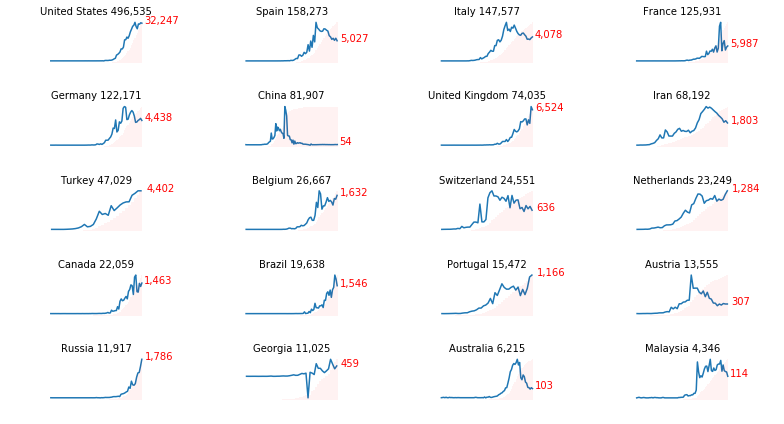

In [11]:
top = 20
# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:top-2].country) + ['Australia', 'Malaysia']
# countries.remove('Cruise Ship')
fig, axes = plt.subplots(ncols=4, nrows=round(len(countries)/4), figsize=(11,6), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    ax.text(until + oneday*2, cdata.loc[until].new_confirmed, format(cdata.loc[until].new_confirmed, ","), color='red')
    ax2 = ax.twinx()
    ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
    ax.set_title(f'{countries[i]} {format(cdata.loc[until].confirmed, ",")}', fontsize=10)
    ax.axis('off')
    ax2.axis('off')
plt.tight_layout()
plt.show()

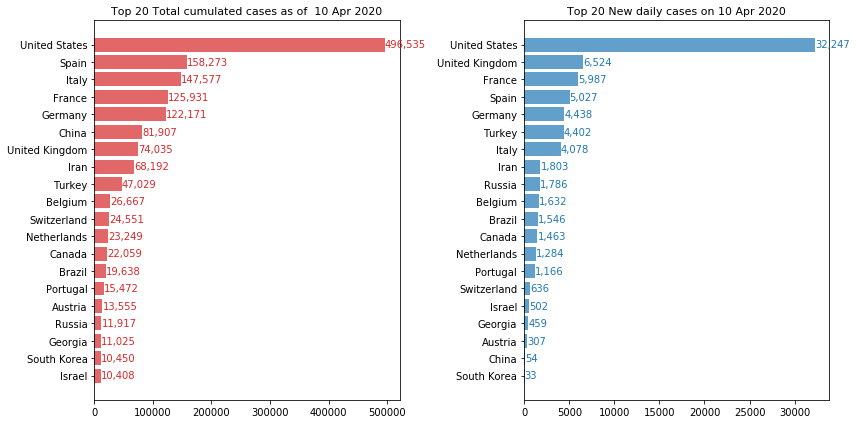

In [12]:
mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases as of  ','New daily cases on ']
colors = ['C3','C0']
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
for i, ax in zip(range(len(cols)), axes.flat):
    data = latest[:top][['country',cols[i]]].reset_index(drop=True).set_index('country').sort_values(by=cols[i])
    ax.barh(data.index, data[cols[i]], color=colors[i], alpha=0.7)
    ax.set_title(f'Top {top} {titles[i]}{date.day} {mdict[date.month]} 2020', fontsize='11')
    for n, v in enumerate(data[cols[i]]):
        ax.text(v, n, format(v, ","), va='center', fontsize=10, color=colors[i])
plt.tight_layout()
plt.savefig('img/total_cases_bar', pad_inches=0)
plt.show()

In [13]:
threshold = 50 # set min threshold

cols = ['country','confirmed','new_confirmed','growth','growth_avg','growth_avg_7']
df2 = df1a[cols].reset_index()
df2 = df2.sort_values('date')

print(f'\nTop 20 countries with the highest day-on-day growth as of {date.day}/{date.month}/2020')
growthdata = df2.loc[(df2.date==date) & (df2.confirmed > 100)].sort_values(by='growth', ascending=False).set_index('country', drop=True)
growthdata[['confirmed','growth','growth_avg']][:20]


Top 20 countries with the highest day-on-day growth as of 10/4/2020


,confirmed,growth,growth_avg
country,,,
Ecuador,7161,1.442,1.215
Belarus,1981,1.333,1.322
Bangladesh,424,1.285,1.376
Guatemala,126,1.189,1.174
Russia,11917,1.176,1.167
Ukraine,2203,1.164,1.138
Kosovo,250,1.152,1.140
Ireland,8089,1.142,1.123
Hungary,1190,1.142,1.133



Day-to-day % growth of new confirmed cases for 4 weeks prior to 10 Apr 2020


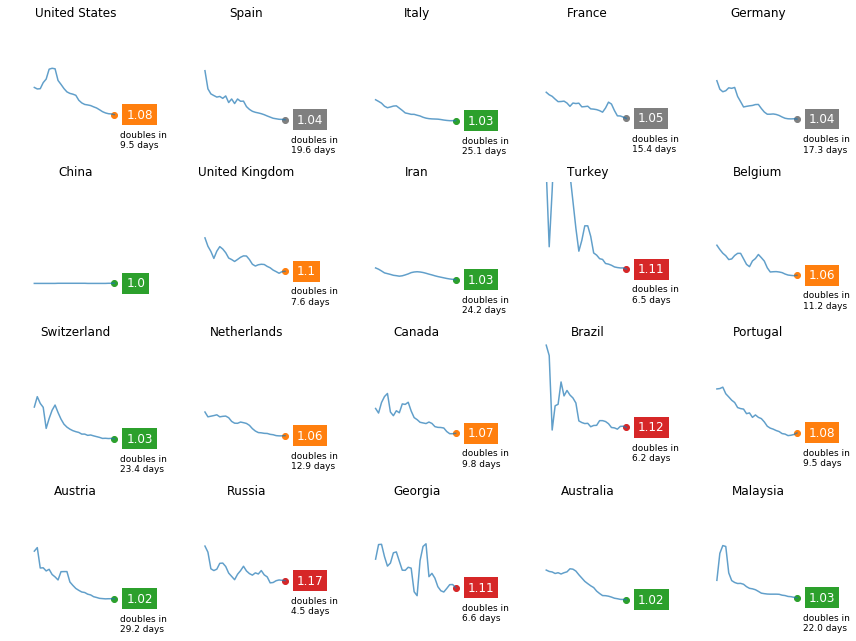

In [14]:
countries = list(latest[:18].country) + ['Australia', 'Malaysia']

print(f'\nDay-to-day % growth of new confirmed cases for 4 weeks prior to {date.day} {mdict[date.month]} 2020')
fig, axes = plt.subplots(ncols=5, nrows=round(len(countries)/5), figsize=(12,9), constrained_layout=True)
col = ['growth_avg']
for i, ax in zip(range(len(countries)), axes.flat):
    data = df2[df2.country==countries[i]].iloc[-28:].reset_index(drop=True)
    ax.plot(data[col].clip(1)[:], alpha=0.7)
    latest_growth = data[col].iloc[-1]
    if latest_growth[0] < 2**(1/21):
        color = 'C2'
    elif latest_growth[0] < 2**(1/14):
        color = 'C7'
    elif latest_growth[0] < 2**(1/7):
        color = 'C1'
    else: color = 'C3'
    double_days = f'doubles in\n{round(math.log(2)/math.log(latest_growth),1)} days' if latest_growth[0] > 2**(1/30) else ''
    ax.scatter(data.index.max(), latest_growth, marker='o', color=color)
    #ax.hlines(0,data.index.min(),data.index.max(), alpha=0.1)
    ax.text(data.index.max()+4, latest_growth, str(round(latest_growth[0],2)),
            color='white', ha='left', va='center', size=12, bbox=dict(facecolor=color, edgecolor='none'))
    ax.text(data.index.max()+2, latest_growth-0.2, double_days, ha='left', va='center', size=9)
    ax.set_ylim(0.9, 1.8)
    ax.axis('off')
    ax.set_title(countries[i], fontsize=12)
plt.tight_layout()
plt.savefig('img/growth', pad_inches=0)
plt.savefig(f'img_archive/growth_{str(date)[:10]}', pad_inches=0)
plt.show()

In [15]:
print('Day-to-day % growth of new confirmed cases over the past 7 days')
dfgrowth = pd.pivot_table(df2, values=['growth'], index=['country'], columns=['date'], aggfunc='sum').loc[countries]
dfgrowth.iloc[:,-7:]

Day-to-day % growth of new confirmed cases over the past 7 days


growth                                              \
date           2020-04-04 2020-04-05 2020-04-06 2020-04-07 2020-04-08   
country                                                                 
United States       1.120      1.096      1.082      1.088      1.080   
Spain               1.053      1.048      1.041      1.041      1.036   
Italy               1.037      1.034      1.029      1.028      1.027   
France              1.205      1.045      1.074      1.080      1.040   
Germany             1.057      1.043      1.042      1.043      1.042   
China               1.000      1.000      1.000      1.001      1.001   
United Kingdom      1.126      1.112      1.078      1.090      1.071   
Iran                1.049      1.043      1.039      1.035      1.030   
Turkey              1.144      1.131      1.116      1.129      1.121   
Belgium             1.079      1.076      1.067      1.056      1.067   
Switzerland         1.035      1.036      1.028      1.037      1.030   
Netherlands         1.072      1.056      1.057      1.051      1.051   
Canada              1.144      1.133      1.067      1.061      1.081   
Brazil              1.144      1.087      1.117      1.115      1.152   
Portugal            1.082      1.052      1.066      1.048      1.061   
Austria             1.029      1.021      1.025      1.022      1.026   
Russia              1.140      1.139      1.177      1.182      1.157   
Georgia             1.073      1.068      1.090      1.156      1.160   
Australia           1.033      1.030      1.021      1.020      1.016   
Malaysia            1.060      1.040      1.048      1.038      1.035   

                                      
date           2020-04-09 2020-04-10  
country                               
United States       1.076      1.071  
Spain               1.038      1.033  
Italy               1.028      1.028  
France              1.048      1.050  
Germany             1.043      1.038  
China               1.001      1.001  
United Kingdom      1.118      1.097  
Iran                1.031      1.027  
Turkey              1.115      1.103  
Belgium             1.061      1.065  
Switzerland         1.033      1.027  
Netherlands         1.056      1.058  
Canada              1.067      1.071  
Brazil              1.119      1.085  
Portugal            1.084      1.082  
Austria             1.024      1.023  
Russia              1.168      1.176  
Georgia             1.093      1.077  
Australia           1.019      1.017  
Malaysia            1.033      1.027

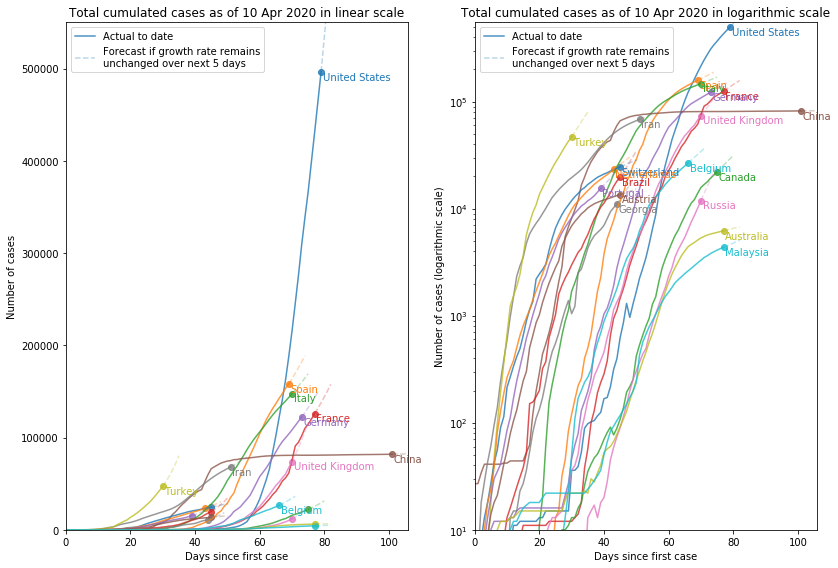

In [16]:
xmax = 45
future_days = 5
ylabels = ['Number of cases', 'Number of cases (logarithmic scale)']
latestdate = f'{date.day} {mdict[date.month]} 2020'
titles = [f'Total cumulated cases as of {latestdate} in linear scale',
          f'Total cumulated cases as of {latestdate} in logarithmic scale']
fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=2) 
for s in range(2): # one for log scale, one for regular scale
    for i, country in enumerate(countries):
        color = f'C{i}' if i < 10 else f'C{str(i)[-1]}'   
        # Data for actual
        data = df2.loc[(df2.country==country), 'confirmed'].reset_index(drop=True)
        ax[s].plot(data, alpha=0.8, color=color, label='Actual to date')
        ax[s].scatter(data.index.max(), data.iloc[-1], alpha=0.8, color=color)
        if s==0:
            if i<10 : ax[s].text(data.index.max()+0.5, data.max(), country,
                                 va='top', ha='left', fontsize=10, color=color)
        else:
            ax[s].text(data.index.max()+0.5, data.max(), country, va='top', ha='left', fontsize=10, color=color)
        # Data for forecast
        latest_growth = df2.loc[(df2.country==country), 'growth'].rolling(window=3).mean().iloc[-1]
        latest_total = df2.loc[(df2.country==country), 'confirmed'].iloc[-1]
        extrapolate = [data.iloc[-1]]
        new_data = latest_total
        for day in range(future_days):
            new_data = new_data * latest_growth
            extrapolate.append(new_data)
        xdays = range(data.index.max(), data.index.max()+future_days+1)
        ax[s].plot(xdays, extrapolate, alpha=0.3, ls='dashed', color=color, label=f'Forecast if growth rate remains\nunchanged over next {future_days} days')
        if i==0: ax[s].legend()
    if s==1: plt.yscale('log')
    ax[s].set_title(titles[s])
    ax[s].set_xlim(0, df2[df2.country=='China'].reset_index().index.max()+5)
    ax[s].set_ylim(10, 5.5e5)
    ax[s].set_ylabel(ylabels[s])
    ax[s].set_xlabel('Days since first case')
plt.tight_layout()
plt.savefig(f'img/total_cases', pad_inches=0)
plt.savefig(f'img_archive/total_cases_{str(date)[:10]}', pad_inches=0)
plt.show()

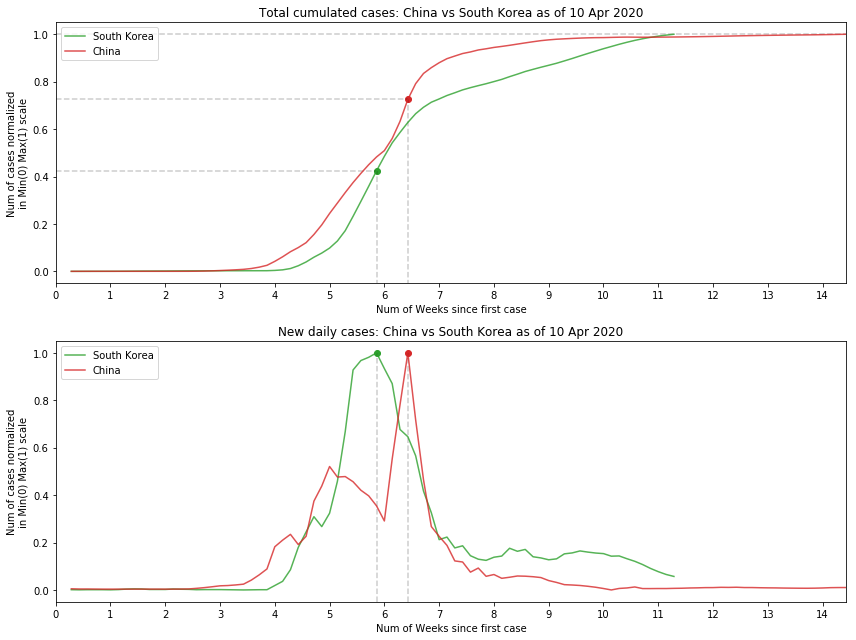

In [17]:
color = ['C2','C3']
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases: China vs South Korea as of', 'New daily cases: China vs South Korea as of']
fig, axes = plt.subplots(figsize=(12,9), nrows=2, ncols=1)
for i, ax in zip(range(len(cols)), axes.flat):
    for c, country in enumerate(['South Korea','China']):
        data0 = df2.loc[df2.confirmed > 0]
        data1 = df2.loc[df2.country==country][cols[i]].rolling(window=3).mean().reset_index(drop=True)
        if i==1:
            peakday = data1[data1==data1.max()].index[0]
        else:
            data2 = df2.loc[df2.country==country][cols[i+1]].rolling(window=3).mean().reset_index(drop=True)
            peakday = data2[data2==data2.max()].index[0]
        scaler = MinMaxScaler()
        data = scaler.fit_transform(np.array(data1).reshape(-1, 1))
        ax.plot(data, label=country, color=color[c], alpha=0.8)
        xmax = df2.loc[df2.country=='China'].reset_index().index.max()
        if i==1:
            ax.vlines(peakday, -0.05, 1, linestyle='dashed', alpha=0.2)
            ax.scatter(peakday, 1, marker='o', color=color[c])
        else:
            ax.vlines(peakday, -1, data[peakday], linestyle='dashed', alpha=0.2)
            ax.hlines(data[peakday], -1, peakday, linestyle='dashed', alpha=0.2)
            ax.hlines(1, -1, xmax, linestyle='dashed', alpha=0.1)
            ax.scatter(peakday, data[peakday], marker='o', color=color[c])
        ax.set_title(f'{titles[i]} {latestdate}')
        ax.set_ylim(-0.05, 1.05)
        ax.set_xlim(0, xmax)
        ax.set_xticks(np.array(range(0,xmax,7)))
        ax.set_xticklabels((np.array(range(0,xmax,7))/7).astype(int))
        ax.set_ylabel('Num of cases normalized\nin Min(0) Max(1) scale')
        ax.set_xlabel('Num of Weeks since first case')
        ax.legend(loc='upper left')
        plt.tight_layout()
plt.savefig('img/china_korea', pad_inches=0)
plt.show()

### 3. Forecasting

In [18]:
# country='United Kingdom'
# rolling=3
# days=300
# fit_start=None
# fit_end=None

# country='Italy'
# rolling=3
# days=270
# fit_start=None
# fit_end='20200319'

# showzero=True
# showpeak=True
# showforecast=True
# A=None
# K=None
# C=None
# Q=None
# B=None
# v=None

# Generalised logistic function (Richard's curve)
def richards(x, A, K, C, Q, B, v):
    y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
    return y

# Fit to Richard's curve model
def predict_plot(country, rolling=1, fit_start=None, fit_end=None, days=130,
                 showzero=True, showpeak=True, showforecast=True,
                 A=None, K=None, C=None, Q=None, B=None, v=None, df2=df2):

    data = df2.loc[df2.country==country].reset_index(drop=True)
    dates = data.date
    latestdate = dates.iloc[-1]

    # # All dates in raw Actuals
    # dates = df2.loc[df2.country==country].reset_index(drop=True).date
    # # All raw Actuals
    # actual0    = df2.loc[df2.country==country, 'confirmed'].reset_index(drop=True)
    # actual0new = df2.loc[df2.country==country, 'new_confirmed'].reset_index(drop=True)

    # Limit Actual data period for model fit
    oneday = pd.Timedelta(1, unit='days')
    fit_start   = pd.to_datetime(fit_start, format='%Y%m%d')
    fit_end     = pd.to_datetime(fit_end, format='%Y%m%d')
    index_start = list(dates[dates==fit_start].index)[0] if fit_start != None else None
    index_end   = list(dates[dates==fit_end+oneday].index)[0] if fit_end != None else None
    actual1 = data.confirmed.iloc[index_start:index_end]

    # Data for model fit input after rolling average
    dropna = range(actual1.index.min(),actual1.index.min()+(rolling-1))
    actual2 = actual1.rolling(window=rolling).mean().drop(dropna) if rolling > 1 else actual1
    xdata = np.array(range(rolling,len(actual2)+rolling))
    ydata = np.array(actual2.values)

    # Auto fit model
    popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
    # Hyperparams of auto fit
    A0, K0, C0, Q0, B0, v0 = popt

    # Overwrite auto fit hyperparams if manual value exists
    A = A0 if A==None else A
    K = K0 if K==None else K
    C = C0 if C==None else C
    Q = Q0 if Q==None else Q
    B = B0 if B==None else B
    v = v0 if v==None else v

    # Calculate prediction over required num of days
    xdata2 = np.array(range(days))
    predcalc = richards(xdata2, A, K, C, Q, B, v)
    pred_index = range(actual2.index.min(), days+actual2.index.min())

    # Forecast dates that overlap with Actuals
    predict_dates1 = list(filter(lambda row: row <= dates.index.max(), pred_index))
    dates_part_1 = []
    for dy in predict_dates1:
        dates_part_1.append(dates.loc[dy]) 
    predict1 = pd.DataFrame(predcalc[:len(dates_part_1)], columns=['predict'], index=pred_index[:len(dates_part_1)]).clip(0)
    data = data.join(predict1)

    # Forecast dates beyond Actuals period
    predict_dates2 = list(filter(lambda row: row > dates.index.max(), pred_index))
    dates_part_2 = []
    for ix in range(len(predict_dates2)):
        dates_part_2.append(dates.max() + oneday * (ix+1))
    predict2 = pd.DataFrame(predcalc[len(dates_part_1):], columns=['predict'], index=pred_index[len(dates_part_1):])
    predict2['date'] = dates_part_2
    predict2['country'] = country

    # Combine both tables
    data = pd.concat([data, predict2])
    # Shift prediction time for rolling avg and remove final nan rows
    data.predict = data.predict.shift(-1*(rolling+1))
    data = data[:-1*(rolling+1)]
    # Calc new cases & growth
    data.predict = data.predict.fillna(-1)
    data.predict = data.predict.astype(int)
    data.predict = data.predict.replace(-1, np.nan)
    data['new_predict'] = data.predict.diff()
    data['new_conf_avg_7'] = round(data.new_confirmed.rolling(window=7).mean())
    data['temp_conf'] = data.apply(lambda row: row.predict if pd.isnull(row.confirmed) else row.confirmed, axis=1)
    data['temp_new'] = data.temp_conf.diff()
    data['new_pred_avg_7'] = round(data.temp_new.rolling(window=7).mean())
    data['p_growth'] = np.nan
    for i in data.index:
        data.iloc[i, data.columns.get_loc('p_growth')] = 0 if data.iloc[i-1].predict == 0 else round(data.iloc[i].predict/data.iloc[i-1].predict,3).clip(1)    
    data['p_gr_avg_7'] = round(data.p_growth.rolling(window=7).mean(),3).clip(1)
    data = data[['date', 'country',
                 'confirmed', 'new_confirmed', 'new_conf_avg_7', 'growth', 'growth_avg_7',
                 'predict', 'new_predict', 'new_pred_avg_7', 'p_growth', 'p_gr_avg_7']]

    # Save df in csv
    data.to_csv(f"dfdata/forecast_{country.replace(' ','_')}.csv")
    data.to_csv(f"img_archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}.csv")

    # Find dates for plot labels
    # Latest available date in raw Actual
    latestindex = data[data.confirmed.isnull()].index.min()-1
    latestdate  = data.date.iloc[latestindex]

    # Date of plateau
    oneday = pd.Timedelta(1, unit='days')
    zeroindex = data.iloc[latestindex:][data.iloc[latestindex:].new_predict < 0.5].index.min()
    to_zero_days  = zeroindex - latestindex
    to_zero_weeks = round(to_zero_days/7)
    zerodate = latestdate + oneday*to_zero_days
    if (to_zero_days < 5) | (np.isnan(zeroindex)): showpeak = False

    # Date of peak
    peakindex = data[data.new_predict==data.new_predict.max()].index[0]
    to_peak_days  = peakindex - latestindex
    to_peak_weeks = round(to_peak_days/7)
    peakdate = latestdate + oneday*to_peak_days
    if to_peak_days < 5: showpeak = False

    # Plot prediction
    fig, ax = plt.subplots(figsize=(12,5), ncols=2, nrows=1)
    mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    if showforecast==True:
        ax[0].plot(data.date, data.predict,  ls='dashed', c='C1', label='Forecast')
        ax[1].plot(data.date, data.new_predict, ls='dashed', c='C1', label='Forecast')

    # Plot actual
    value_latest = data.confirmed.iloc[latestindex]
    value_latest_new = data.new_confirmed.iloc[latestindex]
    ax[0].plot(data.date, data.confirmed, c='C0', label='Actual to date')
    ax[0].scatter(latestdate, int(value_latest), c='C0')
    ax[0].text(latestdate+oneday*2, value_latest, f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(value_latest), ",")} cases', va='top')
    ax[1].plot(data.date, data.new_confirmed, c='C0', label='Actual daily')
    ax[1].scatter(latestdate, int(value_latest_new), color='C0')
    ax[1].text(latestdate+oneday*2, value_latest_new, f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(value_latest_new), ",")} cases', va='top')

    # Plot prediction end points
    if showforecast==True:
        if (showzero==True) & (pd.isna(to_zero_days)==False) :
            ax[0].scatter(zerodate, data.predict.max(), c='C1')      
            predictmax = int(math.ceil(data.predict.max()/100.0))*100 if data.predict.max() > value_latest else int(math.ceil(value_latest/100.0))*100
            zerolabel = f"{int(round(to_zero_weeks))} week{'s' if to_zero_weeks>1 else ''}"
            ax[0].text(zerodate+oneday*2, predictmax, f"{zerodate.day} {mdict[zerodate.month]}\n{format(predictmax, ',')} cases\nin {zerolabel}", va='top')
        if (showpeak==True) & (pd.isna(to_peak_days)==False):
            ax[1].scatter(peakdate, data.new_predict.max(), c='C1')
            peaklabel = f"{int(round(to_peak_weeks))} week{'s' if to_peak_weeks>1 else ''}"
            ax[1].text(peakdate+oneday*2, data.new_predict.max(), f"{peakdate.day} {mdict[peakdate.month]}\nin {peaklabel}", va='top')
        loc_legend = 'center right'

    if showforecast==False:
        ax[0].text(data.date.iloc[0] + oneday*days/2, (data.confirmed.min()+data.confirmed.max())/2, 'Latest forecast\nto be reviewed', bbox=dict(facecolor='none', edgecolor='C1', linewidth=2, linestyle='dashed'), ha='center')
        ax[1].text(data.date.iloc[0] + oneday*days/2, (data.new_confirmed.min()+data.new_confirmed.max())/2, 'Latest forecast\nto be reviewed', bbox=dict(facecolor='none', edgecolor='C1', linewidth=2, linestyle='dashed'), ha='center')
        loc_legend = 'lower right'

    # Plot titles and axis
    ax[0].set_title(f'{country.upper()}\nTotal cumulated cases')
    ax[0].set_ylabel('Num of cumulative cases')    
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[0].legend(loc=loc_legend)

    ax[1].set_title(f'{country.upper()}\nNew daily cases')
    ax[1].set_ylabel('Num of new daily cases')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[1].legend(loc=loc_legend)

    if showforecast==False:
        ax[0].set_xlim(dates.values[0], dates.values[0] + oneday * days)
        ax[1].set_xlim(dates.values[0], dates.values[0] + oneday * days)

    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.savefig(f"img/forecast_{country.replace(' ','_')}", pad_inches=0)
    plt.savefig(f"img_archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}", pad_inches=0)    
    plt.show()

    print(country)
    print(f'Auto fit  : A={int(A0)}, K={int(K0)}, C={round(C0,4)}, Q={round(Q0,4)}, B={round(B0,4)}, v={round(v0,4)}')
    if (A!=A0) | (K!=K0) | (C!=C0) | (Q!=Q0) | (B!=B0) | (v!=v0):
        print(f'Manual fit: A={int(A)}, K={int(K)}, C={round(C,4)}, Q={round(Q,4)}, B={round(B,4)}, v={round(v,4)}')

**Instructions on how to run the model**

In [19]:
# Use predict_plot function to run model by country:
#
# predict_plot('United Kingdom',                         # compulsory
#              rolling=1,                                # optional: number of period of moving avg if > 1
#              fit_start='20200311', fit_end='20200311', # optional: but essential if converge error
#              days=110,                                 # optional: number of days to plot (default 110)
#              A=.., K=.., C=.., Q=.., B=.., v=..        # optional: manual tweak of Richard's curve parameters
#              showzero=True, showpeak=True)             # optional: show or hide date of plateau or peak
#
# 1. Run the function with predict_plot(country)
#
# 2. If error message "Optimal parameters not found" is generated, this means that
#    data points can't be fit into a curve due to failure to converge after 3000 iterations
#
# 3. In case of such error, change fit_start or/and fit_end (dates) and/or rolling period (days)
#    manually until the error disappears and a resonable result is generated.
#
# 4. If the curve overfits and/or it doesn't follow the expected result, tweak A/K/C/Q/B/v
#    parameters manually. Use the auto-generated parameter values shown underneath the plots
#    as a starting point and refer to be guide below on the effect of changing these parameters.

![title](img/richards_curve_params.png)

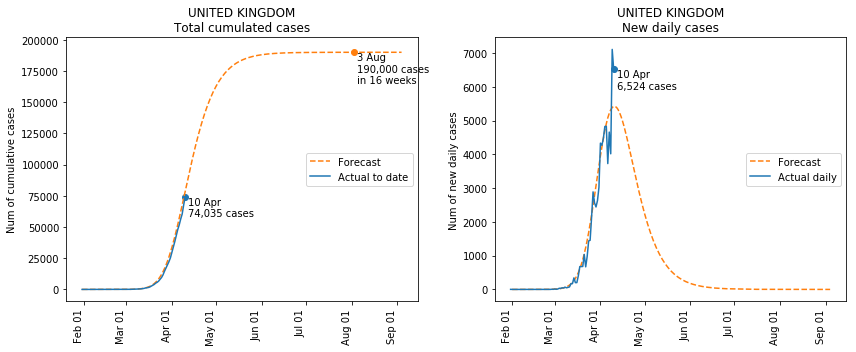

United Kingdom
Auto fit  : A=25, K=448, C=0.1987, Q=29.1266, B=0.0878, v=0.2646


In [20]:
# predict_plot('United Kingdom', days=50, fit_start='20200311', fit_end='20200321')
# predict_plot('United Kingdom', days=50, fit_start='20200317', fit_end='20200329', Q=0.00013)
# predict_plot('United Kingdom', days=120, fit_start='20200317', fit_end='20200329', A=60000, Q=0.00005, showforecast=False)
predict_plot('United Kingdom', days=220)

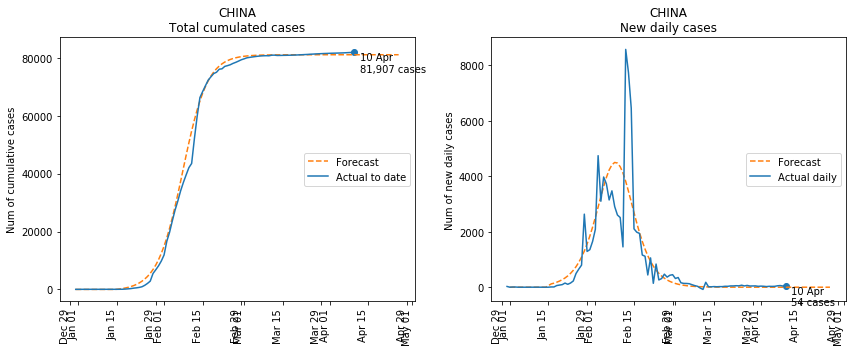

China
Auto fit  : A=-449, K=809, C=0.0113, Q=123.7015, B=0.2262, v=1.0745


In [21]:
predict_plot('China', days=120, showzero=False)

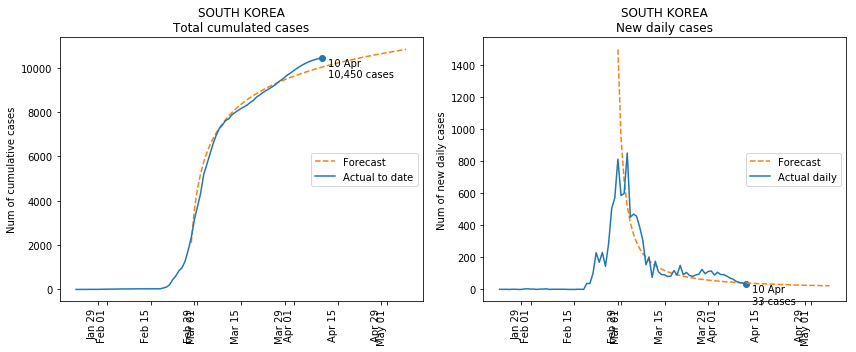

South Korea
Auto fit  : A=12509, K=5698, C=-4.7355, Q=5.0574, B=-0.0323, v=2.6748


In [22]:
#predict_plot('South Korea', rolling=0, days=50, showzero=False, fit_end='20200323')
#predict_plot('South Korea', days=70, showzero=False, fit_start='20200301', fit_end='20200326')
predict_plot('South Korea', days=70, showzero=False, fit_start='20200301', fit_end='20200329')

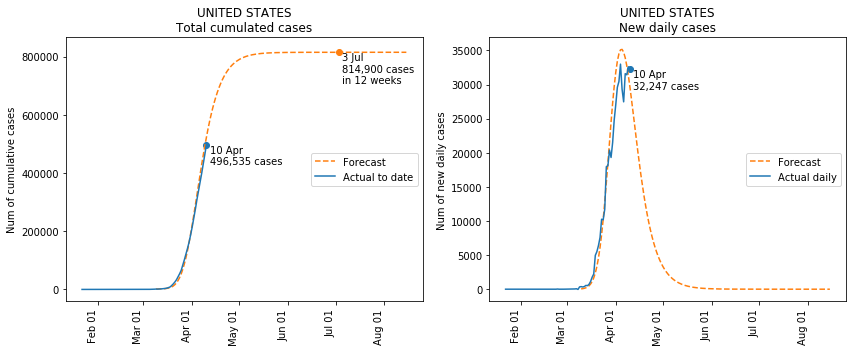

United States
Auto fit  : A=1422, K=2316, C=0.3143, Q=1.3323, B=0.1816, v=0.2133
Manual fit: A=1422, K=5000, C=0.3143, Q=2, B=0.13, v=0.2133


In [23]:
#predict_plot('United States', days=100, fit_start='20200316', fit_end='20200321', B=-1.5)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=100, B=0.3, Q=4)
#predict_plot('United States', days=200, fit_start='20200311', fit_end='20200325', B=0.15, K=4000)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=120, B=0.2, K=3000, Q=2)
predict_plot('United States', fit_start='20200311', fit_end='20200325', days=160, B=0.13, K=5000, Q=2)

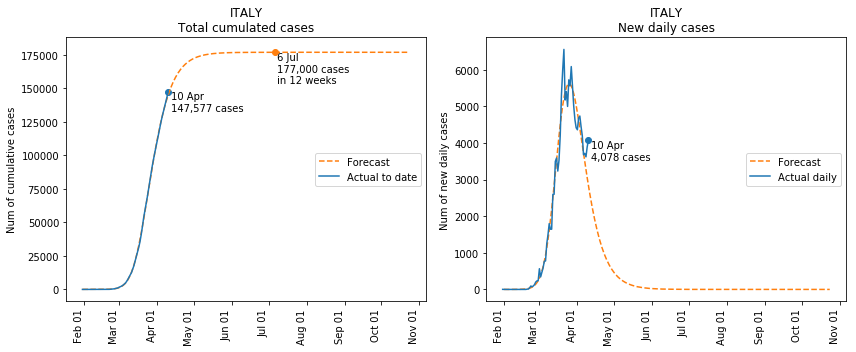

Italy
Auto fit  : A=54, K=3747, C=0.3535, Q=22.1553, B=0.0978, v=0.2687


In [24]:
#predict_plot('Italy', days=270, showpeak=False, fit_end='20200319')
predict_plot('Italy', days=270, rolling=3)

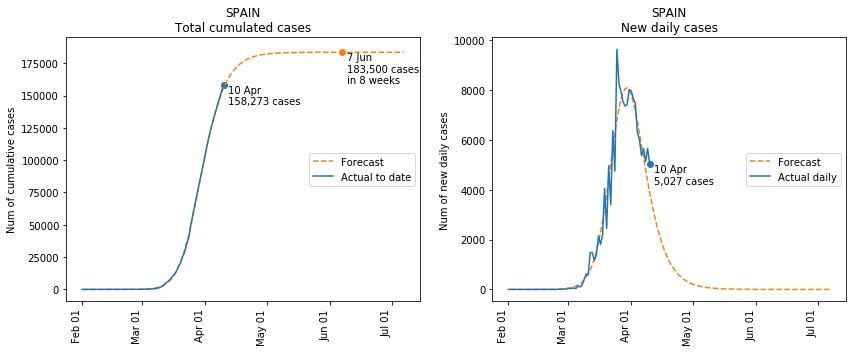

Spain
Auto fit  : A=-41, K=217, C=0.0308, Q=122.18, B=0.1505, v=0.53


In [25]:
#predict_plot('Spain', days=70, fit_start='20200313', fit_end='20200323')
#predict_plot('Spain', days=70, fit_start='20200314', fit_end='20200329')
#predict_plot('Spain', days=70, fit_start='20200316', fit_end='20200329', A=120000, Q=0.00005)
predict_plot('Spain', days=160, rolling=3)

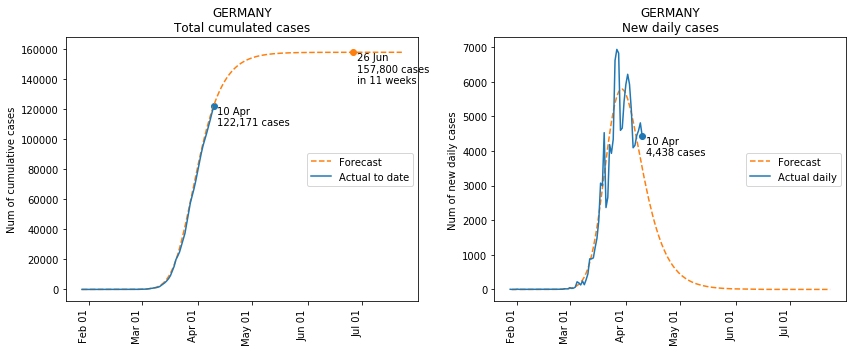

Germany
Auto fit  : A=19, K=1443, C=0.27, Q=97.0714, B=0.1134, v=0.2781


In [26]:
#predict_plot('Germany', rolling=1, days=140, fit_start='20200303', fit_end='20200317', A=-700, B=0.17)
predict_plot('Germany', rolling=2, days=180)

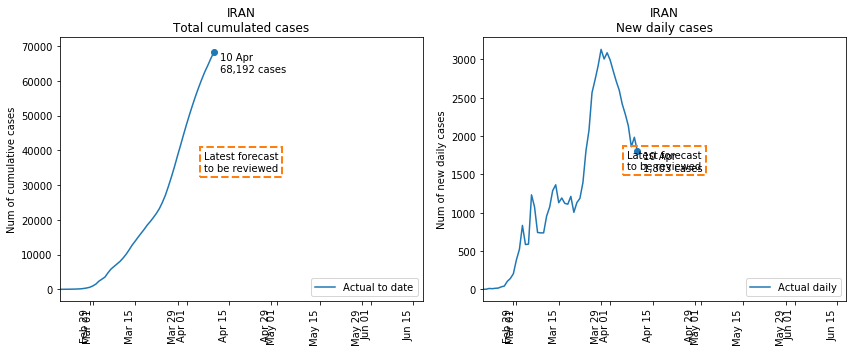

Iran
Auto fit  : A=-4718, K=5420, C=0.3601, Q=0.6561, B=0.0014, v=0.0139


In [27]:
predict_plot('Iran', days=120, fit_end='20200401', showforecast=False)
#predict_plot('Iran', days=200, fit_start='20200307', fit_end='20200321', B=-0.7, v=12)
#predict_plot('Iran', days=200, fit_start='20200309', fit_end='20200321')

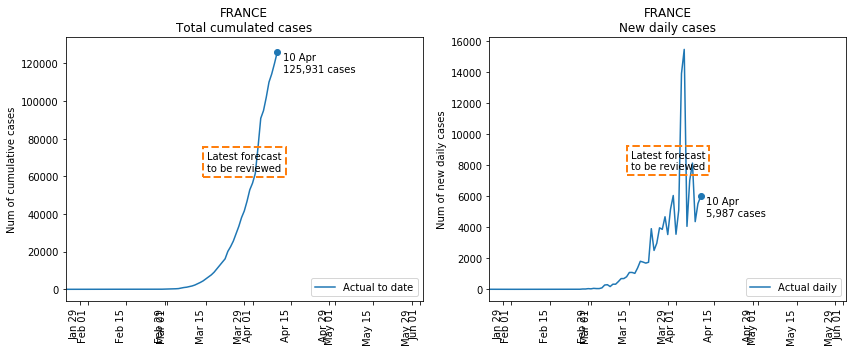

France
Auto fit  : A=67751, K=-70343, C=1.0021, Q=0.0002, B=-0.1731, v=0.0029
Manual fit: A=105000, K=-70343, C=1.0021, Q=0.0001, B=-0.1731, v=0.0029


In [28]:
#predict_plot('France', days=80, fit_start='20200309', fit_end='20200320')
#predict_plot('France', days=80, fit_start='20200314', fit_end='20200329')
predict_plot('France', days=130, fit_start='20200314', fit_end='20200329', A=105000, Q=0.00007, showforecast=False)

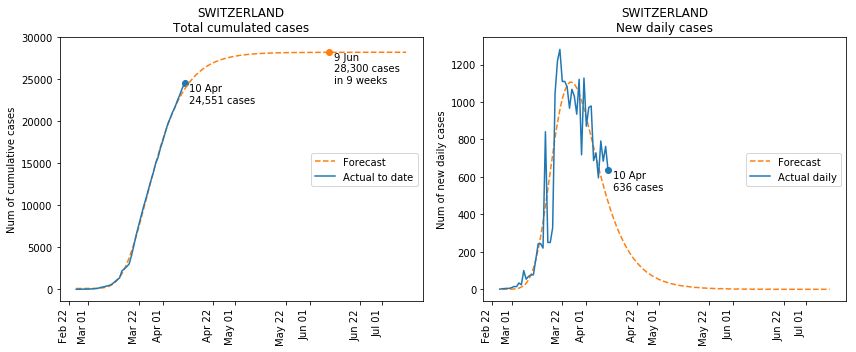

Switzerland
Auto fit  : A=97, K=480, C=0.7136, Q=1.789, B=0.1112, v=0.0785


In [29]:
#predict_plot('Switzerland', days=75, fit_end='20200328', K=240, A=-900)
predict_plot('Switzerland', days=140, fit_end='20200408', rolling=3)

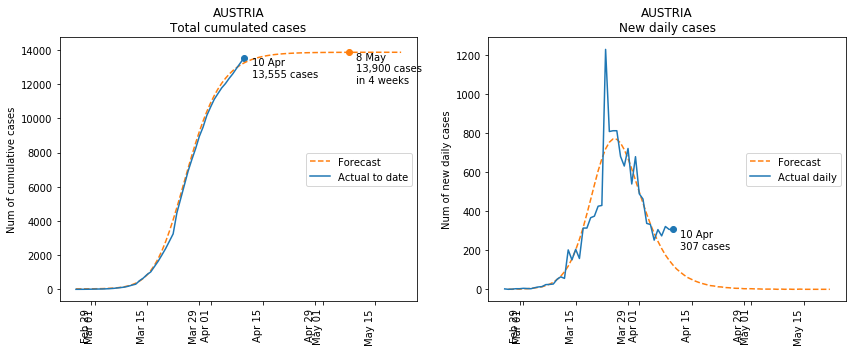

Austria
Auto fit  : A=27, K=354, C=0.1381, Q=26.3121, B=0.1906, v=0.5289


In [30]:
predict_plot('Austria', days=90, rolling=2)

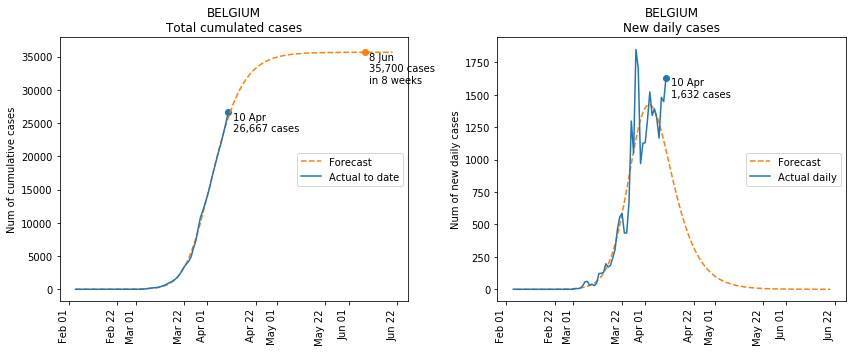

Belgium
Auto fit  : A=15, K=116, C=0.0584, Q=90.9328, B=0.1342, v=0.4842


In [31]:
#predict_plot('Belgium', days=100, fit_start='20200304', A=-120)
predict_plot('Belgium', days=140, rolling=3)

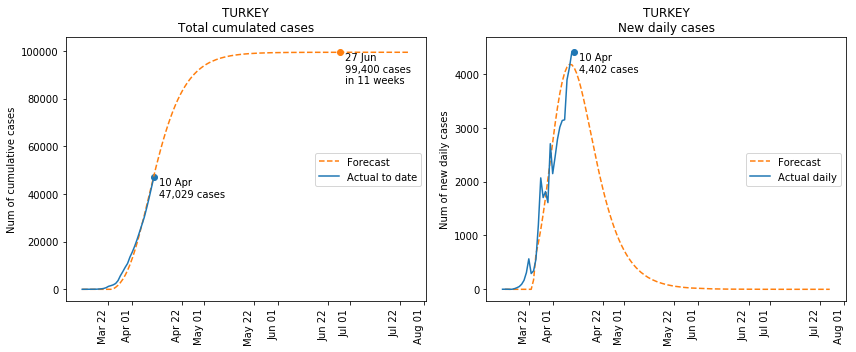

Turkey
Auto fit  : A=13, K=1211, C=0.5119, Q=3.7034, B=0.1593, v=0.1833
Manual fit: A=-1400, K=1211, C=0.5119, Q=3.7034, B=0.123, v=0.1833


In [32]:
predict_plot('Turkey', days=140, fit_end='20200403', A=-1400, B=0.123)

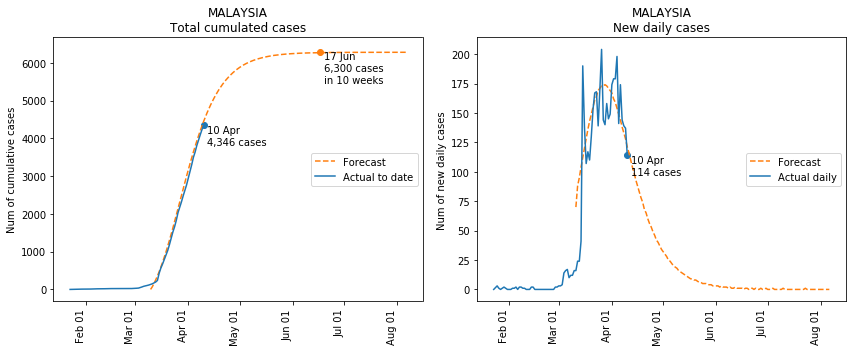

Malaysia
Auto fit  : A=-367, K=324, C=0.5174, Q=0.6486, B=0.0945, v=0.3206
Manual fit: A=-550, K=324, C=0.5174, Q=0.6486, B=0.08, v=0.3206


In [33]:
#predict_plot('Malaysia', days=60, fit_start='20200307', fit_end='20200320', K=300, B=0.3, Q=5)
#predict_plot('Malaysia', days=90, fit_start='20200307', fit_end='20200320', K=400, B=0.2, Q=4)
#predict_plot('Malaysia', days=100, fit_start='20200313', fit_end='20200325')
predict_plot('Malaysia', days=150, fit_start='20200312', fit_end='20200401', A=-550, B=0.08)

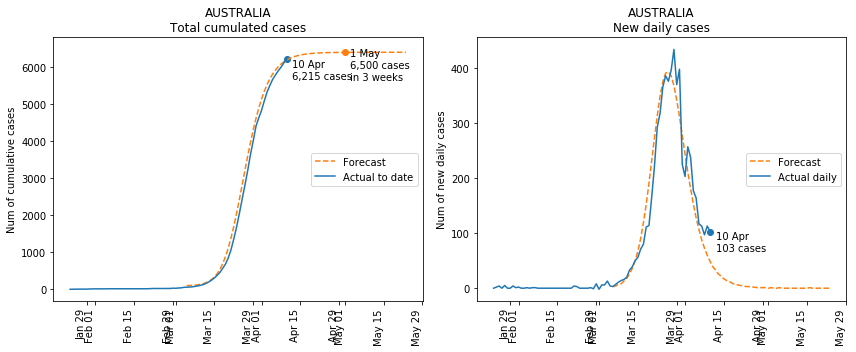

Australia
Auto fit  : A=94, K=1006, C=0.3489, Q=14.7912, B=0.2146, v=0.5446


In [34]:
#predict_plot('Australia', days=60, fit_end='20200317', B=0.25, showpeak=False)
#predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200317', showpeak=False, B=0.28, K=300, Q=12)
#predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200328', A=15, B=0.32)
predict_plot('Australia', days=80, fit_start='20200307')

### 4. Impact of lockdown on growth

In [35]:
lockdates = {'China':         {'start':'20200123', 'end':'20200327'},
             'Switzerland':   {'start':'20200316', 'end':None},
             'Italy':         {'start':'20200307', 'end':None},
             'Austria':       {'start':'20200316', 'end':None},
             'France':        {'start':'20200317', 'end':None},
             'Malaysia':      {'start':'20200318', 'end':None},
             'Spain':         {'start':'20200320', 'end':None},
             'United States': {'start':'20200320', 'end':None},
             'Canada':        {'start':'20200321', 'end':None},
             'Germany':       {'start':'20200322', 'end':None},
             'United Kingdom':{'start':'20200323', 'end':None},
             'Australia':     {'start':'20200331', 'end':None},
             'Thailand':      {'start':'20200402', 'end':None},
             'Singapore':     {'start':'20200407', 'end':None},
             'Japan':         {'start':'20200406', 'end':None},
             'Indonesia':     {'start':'20200410', 'end':None}
            }

In [36]:
# Assign values

# country   = 'South Korea'
# xmin      = pd.to_datetime('20200216', format='%Y%m%d')
# txtmin    = pd.to_datetime('20200225', format='%Y%m%d')

# country   = 'China'
# xmin      = pd.to_datetime('20200115', format='%Y%m%d')
# txtmin    = pd.to_datetime('20200129', format='%Y%m%d')

# country      = 'Malaysia'
# xmin         = pd.to_datetime('20200227', format='%Y%m%d')
# txtmin       = pd.to_datetime('20200312', format='%Y%m%d')

# locklabel    = 'MCO'
# showforecast = None

def plot_lockdown(country, xmin, txtmin, locklabel=None, showforecast=None):

    # Open source
    data = pd.read_csv(f"dfdata/forecast_{country.replace(' ','_')}.csv", index_col=0)
    data.date = pd.to_datetime(data.date)
    
    if xmin!=     None:      xmin = pd.to_datetime(xmin, format='%Y%m%d')
    if txtmin!=   None:    txtmin = pd.to_datetime(txtmin, format='%Y%m%d')

    # Define dates
    latestindex = data[data.confirmed.isnull()].index.min()-1
    latestdate  = data.date.iloc[latestindex]
    if showforecast==None: maxdate = latestdate
    else: maxdate = data.date.max()
    
    if country in list(lockdates.keys()):
        lockstart = pd.to_datetime(lockdates[country]['start'])
        lockstart = latestdate if lockstart > latestdate else lockstart
        lockend   = pd.to_datetime(lockdates[country]['end'])    
        if lockend==None: lockend_now = latestdate
        else: lockend_now = lockend
    else: lockstart, lockend = None, None

    oneday = pd.Timedelta(1, unit='days')
    if xmin==None: xmin=data.date.min()
    if txtmin==None: txtmin=xmin

    fig, ax = plt.subplots(figsize=(12,7))
    mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

    # Plot Daily cases
    ax.plot(data.date, data.new_confirmed, label='New confirmed cases', alpha=0.8, color='C0')
    ax.plot(data.date, data.new_conf_avg_7, label='New confirmed cases: Past 7 days avg (trend)', alpha=0.8, color='C1')

    # Lockdown start/end
    if lockstart != None:
        ax.vlines(lockstart, -50, data.new_confirmed.max()*1.05, alpha=0.8)
        ax.text(lockstart+oneday/2, data.new_confirmed.max()*0.9,
                f'{locklabel} began {lockstart.day} {mdict[lockstart.month]} {lockstart.year}', rotation=90, va='top')
    if lockend != None:
        ax.vlines(lockend, -50, data.new_confirmed.max()*1.05, alpha=0.8)
        ax.text(lockend-oneday*1.5, data.new_confirmed.max()*0.9,
                f'{locklabel} lifted {lockend.day} {mdict[lockend.month]} {lockend.year}', rotation=90, va='top')
    if lockstart != None:
        # Num of cases at start of lockdown
        data0start = data[data.date==lockstart].new_confirmed.values[0]
        data1start = data[data.date==lockstart].new_conf_avg_7.values[0]
        # Num of cases at end of lockdown (or now, if lockdown is ongoing)
        data0end   = data[data.date==lockend_now].new_confirmed.values[0]
        data1end   = data[data.date==lockend_now].new_conf_avg_7.values[0]
        # Days of lockdown
        lockperiod = (lockend_now - lockstart)

    # Num of cases now
    data0now   = data[data.date==latestdate].new_confirmed.values[0]
    data1now   = data[data.date==latestdate].new_conf_avg_7.values[0]

    # Number of cases
    if lockstart != None:
        # Plot num of cases
        ax.scatter(lockstart, data0start, marker='o', color='C0')
        ax.scatter(lockstart, data1start, marker='o', color='C1')
        ax.scatter(lockend_now, data0end, marker='o', color='C0')
        ax.scatter(lockend_now, data1end, marker='o', color='C1')
        ax.text(lockstart-oneday/2, data0start, f'{int(data0start)} cases', ha='right', color='C0')
        ax.text(lockend_now-oneday/2, data0end, f'{int(data0end)} cases', va='top', ha='right', color='C0')
        if abs(data0start - data1start)/data0start > 0.05:
            ax.text(lockstart-oneday/2, data1start, f'{int(data1start)} cases', ha='right', color='C1')
        if abs(data0end - data1end)/data0end > 0.05:
            ax.text(lockend_now-oneday/2, data1end, f'{int(data1end)} cases', va='top', ha='right', color='C1')
        # Draw lockdown period lines
        if data1start/data.new_confirmed.max() < 0.1: lineheight = data.new_confirmed.max()/2
        else: lineheight = data1start
        ax.hlines(lineheight, lockstart, lockend_now, linestyle='dashed', alpha=0.8, color='C2')
        ax.vlines(lockend_now, lineheight, data1end, linestyle='dashed', alpha=0.8, color='C2')
        if lockend != None: into='of'
        else: into='into'
        ax.text(lockstart+lockperiod/2, lineheight, f'{lockperiod.days+1} days {into} {locklabel}', va='center', ha='center',
                bbox=dict(facecolor='yellow', edgecolor='C2', linewidth=2, linestyle='dashed', alpha=0.8))
    if (lockstart == None) | (lockend != None):
        # Plot latest cases
        ax.scatter(latestdate, data0now, marker='o', color='C0')
        ax.scatter(latestdate, data1now, marker='o', color='C1')
        ax.text(latestdate, data0now, f'{int(data0now)} cases', va='top', ha='right', color='C0')

    # Cumulative cases
    ax2 = ax.twinx()
    ax2.bar(data.date, data.confirmed, label='Cumulative confirmed cases', color='C3', width=0.9, alpha=0.05)
    for i in data[(data.date>=txtmin) & (data.date<=maxdate)].index:
        if data.iloc[i].growth >= 1.1: color='C3'
        elif data.iloc[i].growth >= 1.01: color='C0'
        else: color='C2'
        ax2.text(data.iloc[i].date, data.iloc[i].confirmed, f'+{round((data.growth.iloc[i]-1)*100,1)}%',
                 rotation=90, ha='center', va='top', color=color, fontsize=8)
    # Axis labels 
    ax.set_xlim(xmin, maxdate+oneday)
    ax.set_ylim(0, data.new_confirmed.max()*1.05)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate(rotation=90)
    ax.set_ylabel('Num of new confirmed cases')
    ax2.set_ylabel('Num of cumulative confirmed case')
    # plt.annotate('Source: John Hopkins University Hospital based on 00:00 GMT daily reporting cut-off time.\nNew reported cases in the chart are assumed to be in real time based on official figures but a delay of around 48 hours is more likely due to backlogs of RT_PCR.',
    #              (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)

    # Legends
    ax.legend(loc='upper left')
    if data0now/data.new_confirmed.max() < 0.15: legend2loc = 'center right'
    else: legend2loc = 'lower right'
    ax2.legend(loc=legend2loc, title='+%        Day-on-day growth')
    ax.set_title(country, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"img/lockdown_{country.replace(' ','_')}", pad_inches=0)
    plt.show()

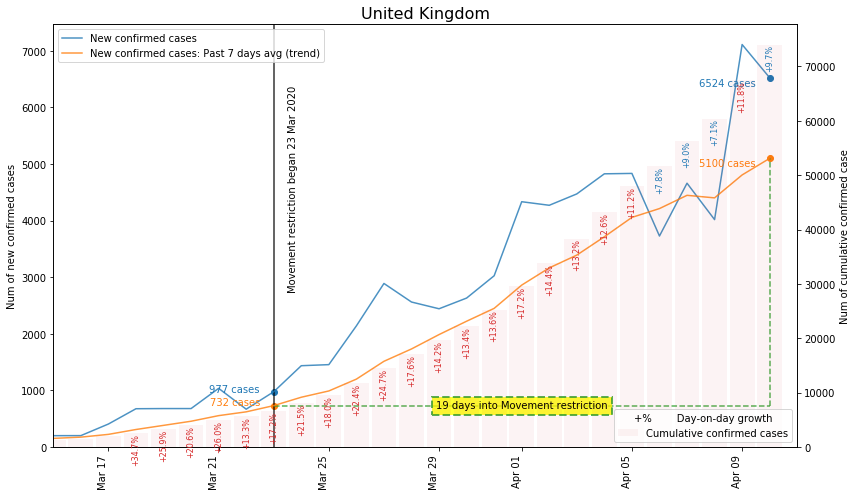

In [37]:
plot_lockdown('United Kingdom', locklabel='Movement restriction', xmin='20200315', txtmin='20200318')

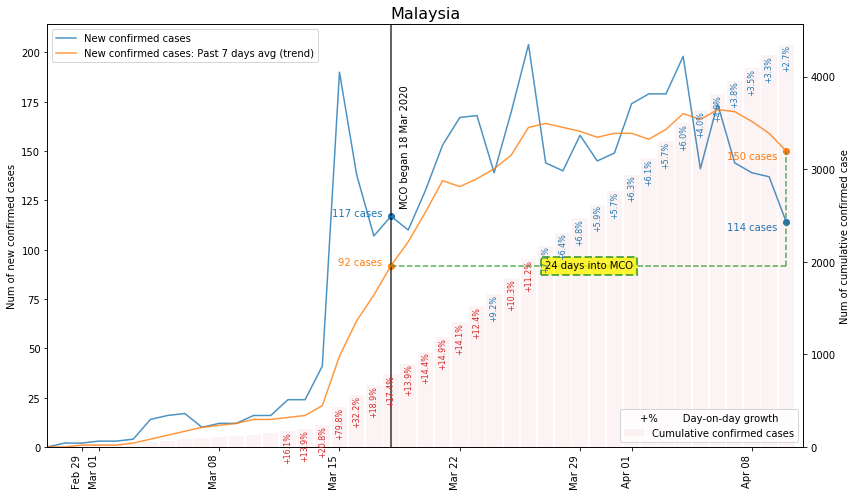

In [38]:
plot_lockdown('Malaysia', locklabel='MCO', xmin='20200227', txtmin='20200312')

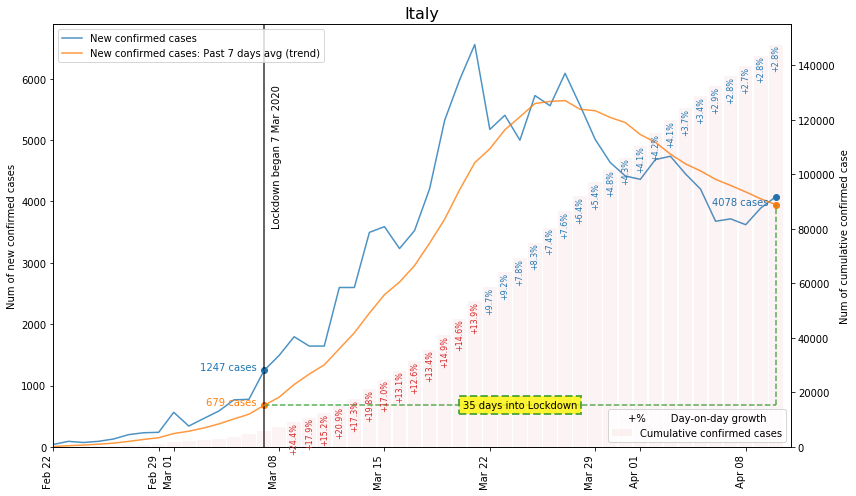

In [39]:
plot_lockdown('Italy', locklabel='Lockdown', xmin='20200222', txtmin='20200309')

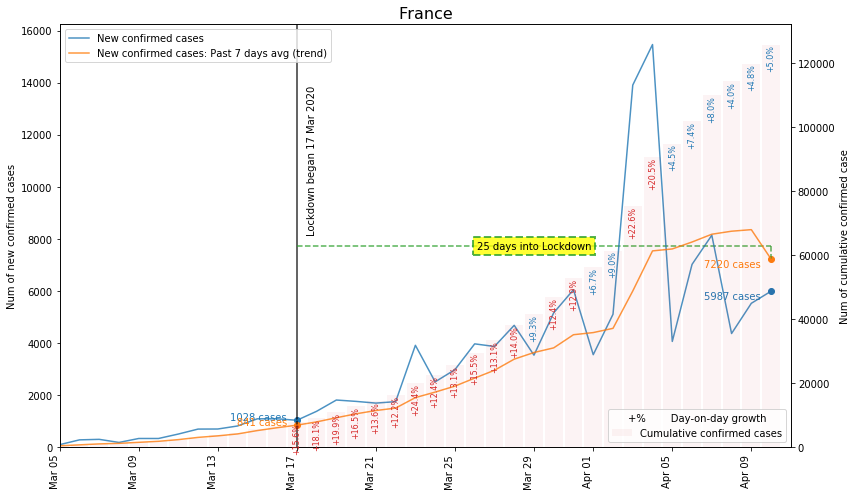

In [40]:
plot_lockdown('France', locklabel='Lockdown', xmin='20200305', txtmin='20200317')

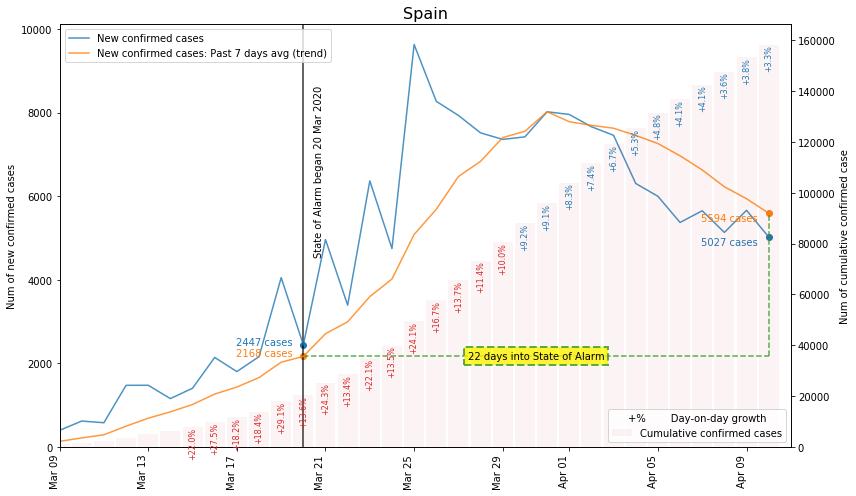

In [41]:
plot_lockdown('Spain', locklabel='State of Alarm', xmin='20200309', txtmin='20200315')

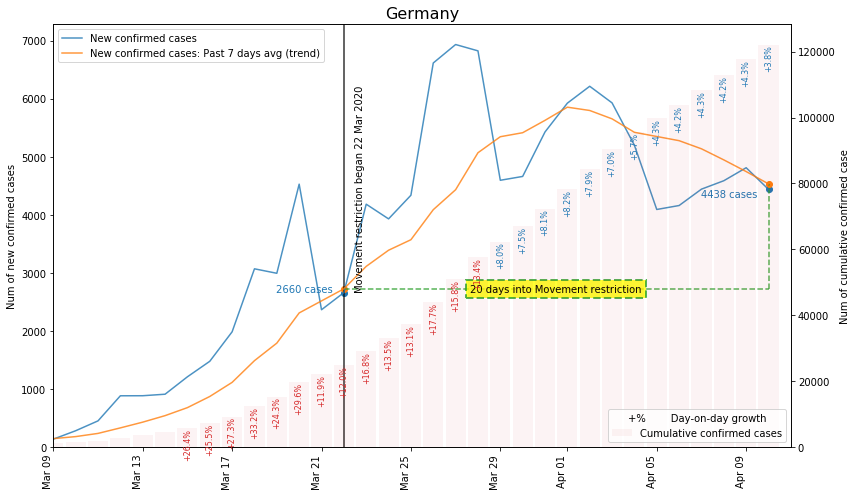

In [42]:
plot_lockdown('Germany', locklabel='Movement restriction', xmin='20200309', txtmin='20200315')

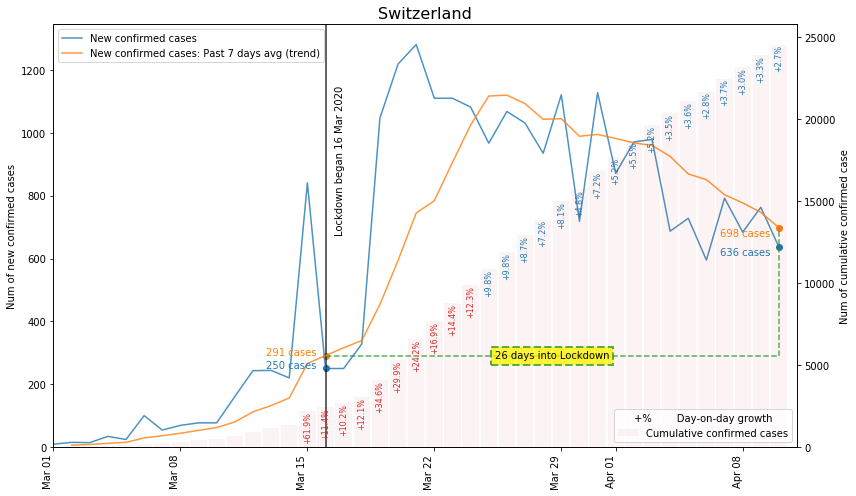

In [43]:
plot_lockdown('Switzerland', locklabel='Lockdown', xmin='20200301', txtmin='20200315')

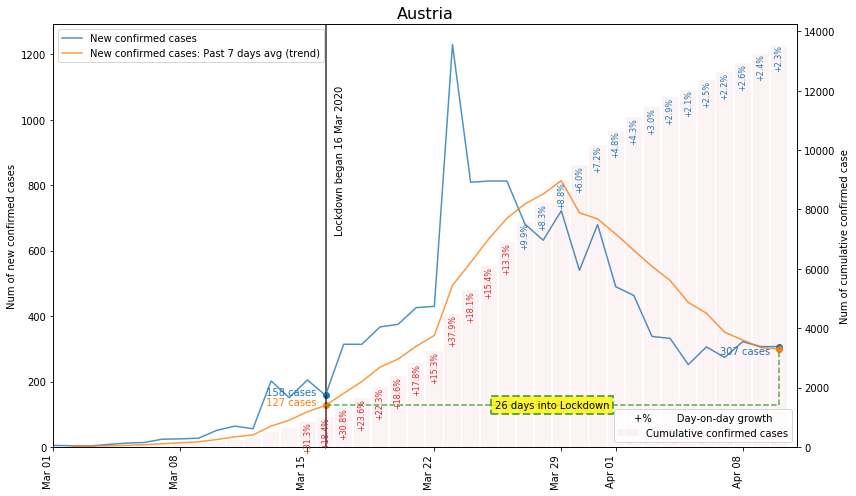

In [44]:
plot_lockdown('Austria', locklabel='Lockdown', xmin='20200301', txtmin='20200315')

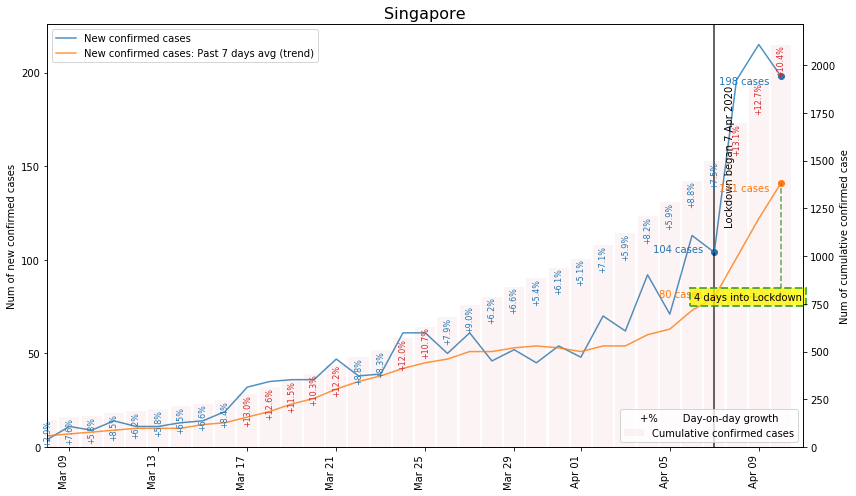

In [45]:
plot_lockdown('Singapore', locklabel='Lockdown', xmin='20200308', txtmin='20200308')

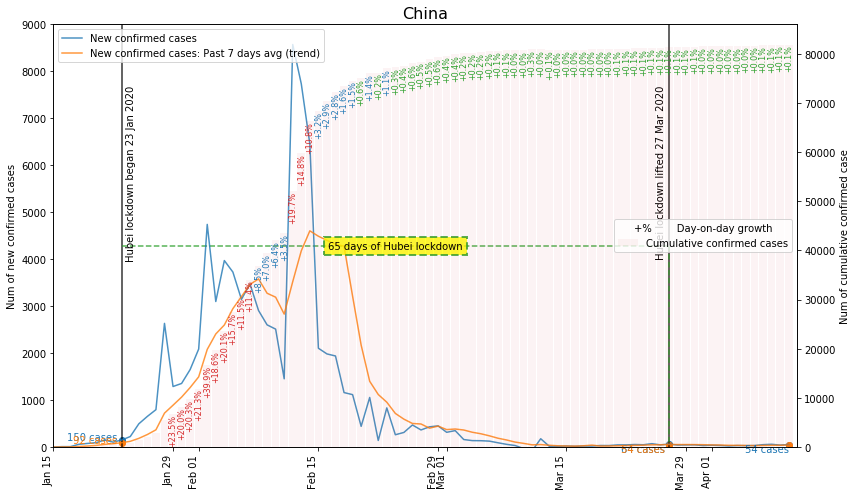

In [46]:
plot_lockdown('China', locklabel='Hubei lockdown', xmin='20200115', txtmin='20200129')

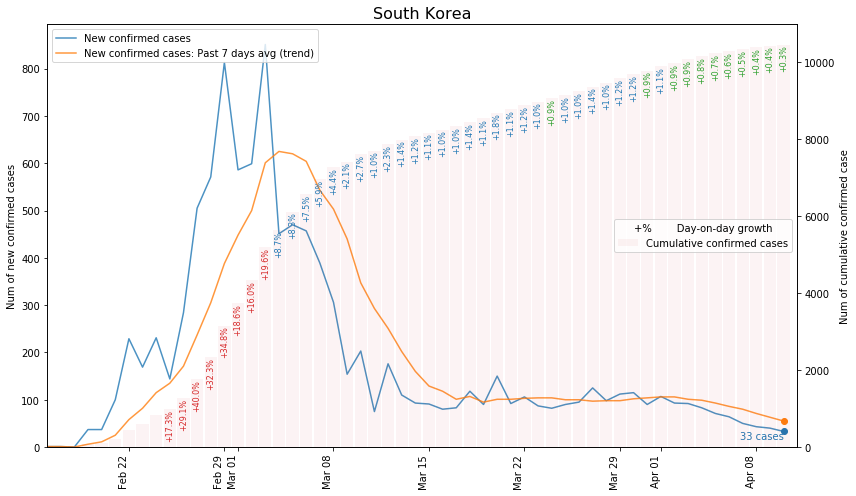

In [47]:
plot_lockdown('South Korea', xmin='20200216', txtmin='20200225')

In [48]:
def plot_gov_measures(countries, title=None, footnote=None, filename=0):
    # Latest available data
    latestdate = df1.index.max()
#     if len(oxford[oxford.country.isin(countries)].loc[latestdate].country) < len(countries):
#         latestdate = df1.index.max() - oneday # if Oxford data update is behind John Hopkins

    # Formula to shift text labels in case of overlap
    ranking = oxford[oxford.country.isin(countries)].loc[latestdate][['country','stringency']].sort_values(by='stringency').reset_index(drop=True).sort_values('stringency', ascending=False)
    ranking['countrank'] = 1
    for i in range(1,len(ranking)+1):
        temp = ranking.iloc[:i]
        countrank = (temp.stringency==temp.iloc[i-1].stringency).sum()
        ranking.iloc[i-1, -1] = countrank
    shift_y = ranking.set_index('country').countrank

    fig, ax = plt.subplots(figsize=(12,8))
    for c, country in enumerate(ranking.country):
        data = oxford[oxford.country==country].loc[:latestdate]
        color = 'black' if country=='Malaysia' else (f'C{c}' if i < 10 else f'C{str(c)[-1]}')
        if country in list(lockdates.keys()):
            lockstart = pd.to_datetime(lockdates[country]['start'])
            lockstart = latestdate if lockstart > latestdate else lockstart
            lockend   = pd.to_datetime(lockdates[country]['end'])
            plt.plot(data.loc[:lockstart].stringency, color=color, lw=1, label='Outside lockdown period')
            plt.plot(data.loc[lockstart:lockend].stringency, color=color, lw=2.5, label='During lockdown period')
            plt.scatter(lockstart, data.loc[lockstart].stringency, color=color, s=60)
            if lockend != None:
                plt.scatter(lockend, data.loc[lockend].stringency, color=color, s=60)
                plt.text(lockend+oneday, data.loc[lockend].stringency, f'{country} (end)', va='center', color=color)
                plt.plot(data.loc[lockend:].stringency, color=color, lw=1)
            else:
                plt.scatter(latestdate, data.loc[latestdate].stringency, color=color, s=60)
            if c==0: ax.legend(loc='upper left', title='Legend')
        else:
            plt.plot(data.stringency, color=color, lw=1)
        plt.text(data.index[-1]+oneday, data.stringency[-1] - (shift_y[country]-1)*2.5,
                 country, va='center', color=color)

    ax.set_xlim(df1.index.min()-oneday*3, latestdate+oneday*14)
    title = 'Government policies stringency index in fighting Covid-19' if title==None else title
    ax.set_title(title)
    ax.set_ylabel('0 Weakest <--- Govt response stringency index ---> 100 Strongest')        
    plt.annotate(f'Source: Hale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020). Oxford COVID-19 Government Response Tracker\n{footnote}',
                 (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.savefig(f"img/stringency_msia_timeline_{filename}", pad_inches=0)
    plt.show()

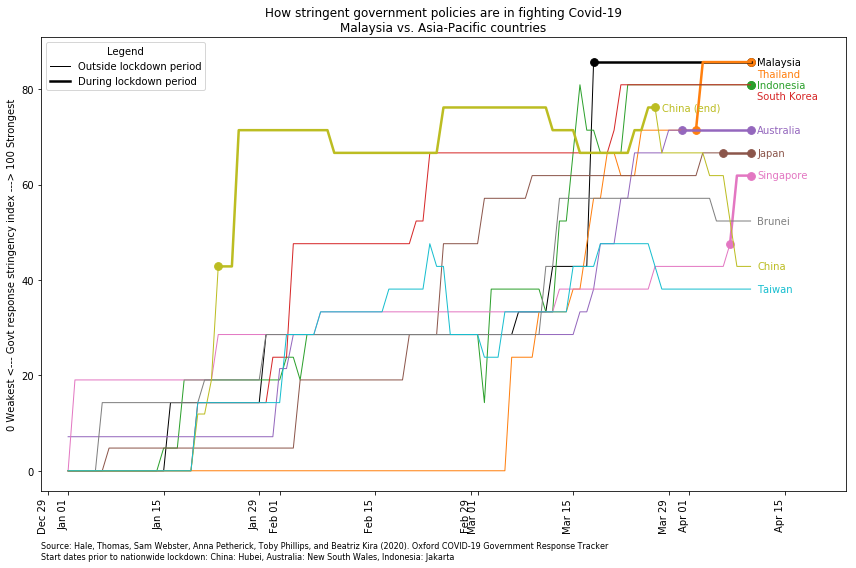

In [49]:
countries = ['Malaysia', 'China', 'South Korea', 'Taiwan', 'Japan',
             'Singapore', 'Thailand', 'Brunei', 'Indonesia', 'Australia']

plot_gov_measures(countries,
                  title='How stringent government policies are in fighting Covid-19\nMalaysia vs. Asia-Pacific countries',
                  footnote='Start dates prior to nationwide lockdown: China: Hubei, Australia: New South Wales, Indonesia: Jakarta',
                  filename='asiapac')

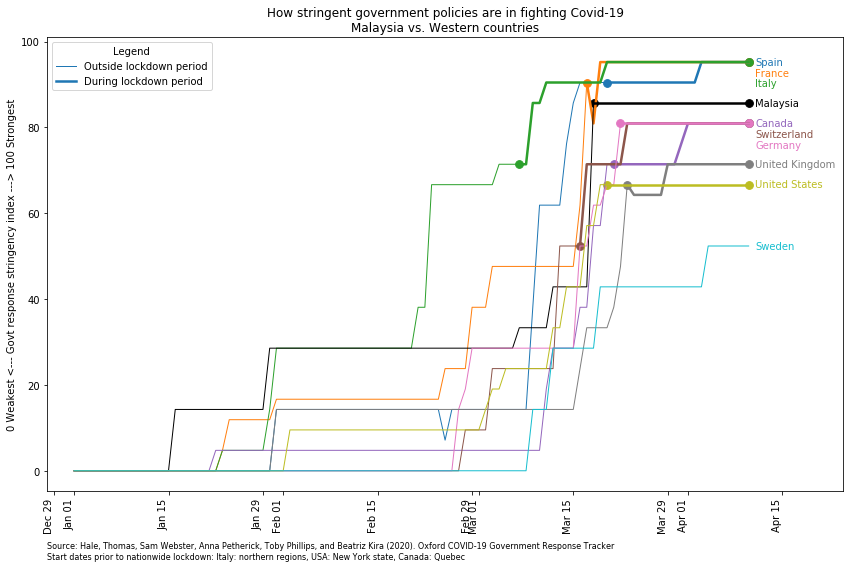

In [50]:
countries = ['Malaysia', 'Spain', 'Italy', 'France', 'Germany', 'Switzerland', 'Sweden',
             'United Kingdom', 'United States', 'Canada']

plot_gov_measures(countries,
                  title='How stringent government policies are in fighting Covid-19\nMalaysia vs. Western countries',
                  footnote='Start dates prior to nationwide lockdown: Italy: northern regions, USA: New York state, Canada: Quebec',
                  filename='west')

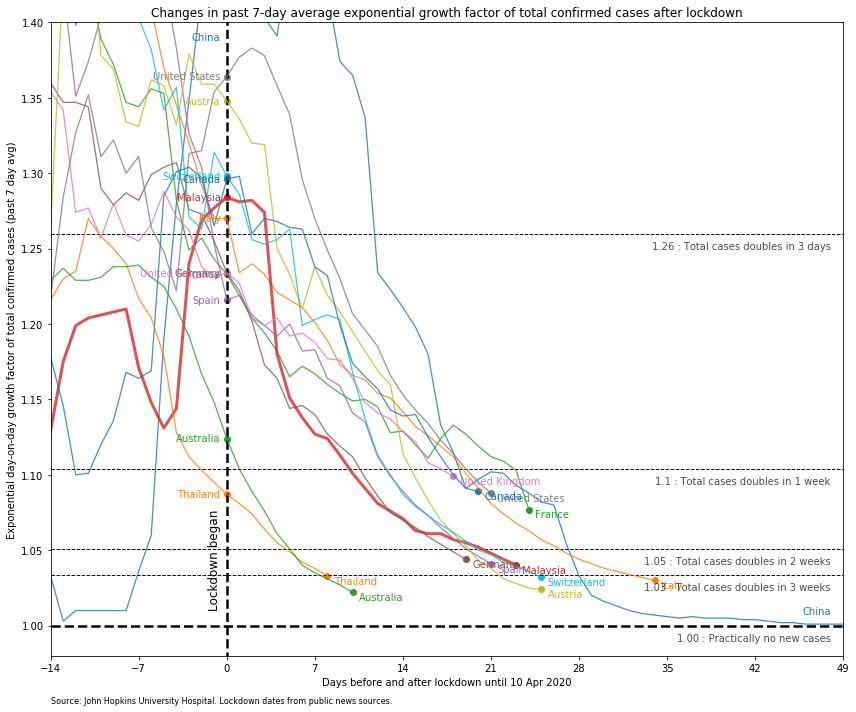

In [51]:
countries = ['China', 'Italy', 'France', 'Malaysia', 'Spain', 'Germany', 'United Kingdom',
             'United States', 'Austria', 'Switzerland', 'Canada', 'Thailand', 'Australia']
fig, ax = plt.subplots(figsize=(12,10))
xmax=49
for c, country in enumerate(countries):
    lockstart = pd.to_datetime(lockdates[country]['start'])
    data = df1a[df1a.country==country].reset_index()
    data['dminus'] = data.date.apply(lambda row: (row - lockstart).days)
    dayzero = data[data.date==lockstart].new_confirmed
    data['new_conf_index'] = data.new_confirmed.apply(lambda row: row/dayzero*100).astype(int)
    data = data.set_index('date')
    color = f'C{c}' if c < 10 else f'C{str(c)[-1]}'
    lw = 3 if country=='Malaysia' else 1.3
    measure = 'growth_avg_7'
    plt.plot(data.dminus, data[measure], label=country, color=color, alpha=0.8, lw=lw)
    plt.scatter(0, data[data.dminus==0][measure], color=color)
    plt.scatter(data.dminus.max(), data[measure][0], color=color)
    
    xpos = xmax-1 if country=='China' else data.dminus.max()+0.5
    ypos = data[data.dminus==xmax][measure]+0.005 if country=='China' else data[measure][0]
    xha = 'right' if country=='China' else 'left'
    xva = 'bottom' if country=='China' else 'top'
    plt.text(xpos, ypos, country, color=color, ha=xha, va=xva)    
    ypos0 = 1.39 if country=='China' else data[data.dminus==0][measure]
    plt.text(-0.5, ypos0, country, color=color, va='center', ha='right')

plt.vlines(0,0.95,1.5, linewidth=2.5, linestyle='--')
plt.text(-1.5,1.01,'Lockdown began', rotation=90, va='bottom', fontsize=12)
plt.hlines(2**(1/3),-14,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-1, 2**(1/3)-0.01, f'{round(2**(1/3),2)} : Total cases doubles in 3 days', ha='right', alpha=0.7)
plt.hlines(2**(1/7),-14,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-1, 2**(1/7)-0.01, f'{round(2**(1/7),2)} : Total cases doubles in 1 week', ha='right', alpha=0.7)
plt.hlines(2**(1/14),-14,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-1, 2**(1/14)-0.01, f'{round(2**(1/14),2)} : Total cases doubles in 2 weeks', ha='right', alpha=0.7)
plt.hlines(2**(1/21),-14,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-1, 2**(1/21)-0.01, f'{round(2**(1/21),2)} : Total cases doubles in 3 weeks', ha='right', alpha=0.7)
plt.hlines(1,-14,xmax, linewidth=2.5, linestyle='--')
plt.text(xmax-1, 0.99, '1.00 : Practically no new cases', ha='right', alpha=0.7)

ax.set_ylim(0.98,1.4)
ax.set_xlim(-14,xmax)
ax.set_xticks(range(-14,xmax+1,7))
ax.set_ylabel('Exponential day-on-day growth factor of total confirmed cases (past 7 day avg)')
ax.set_xlabel(f'Days before and after lockdown until {date.day} {mdict[date.month]} 2020')
ax.set_title('Changes in past 7-day average exponential growth factor of total confirmed cases after lockdown')
source='John Hopkins University Hospital.'
footnote='Lockdown dates from public news sources.'
plt.annotate(f'Source: {source} {footnote}',
             (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/lockdown_msia_post_lockdown_1", pad_inches=0)
plt.show()

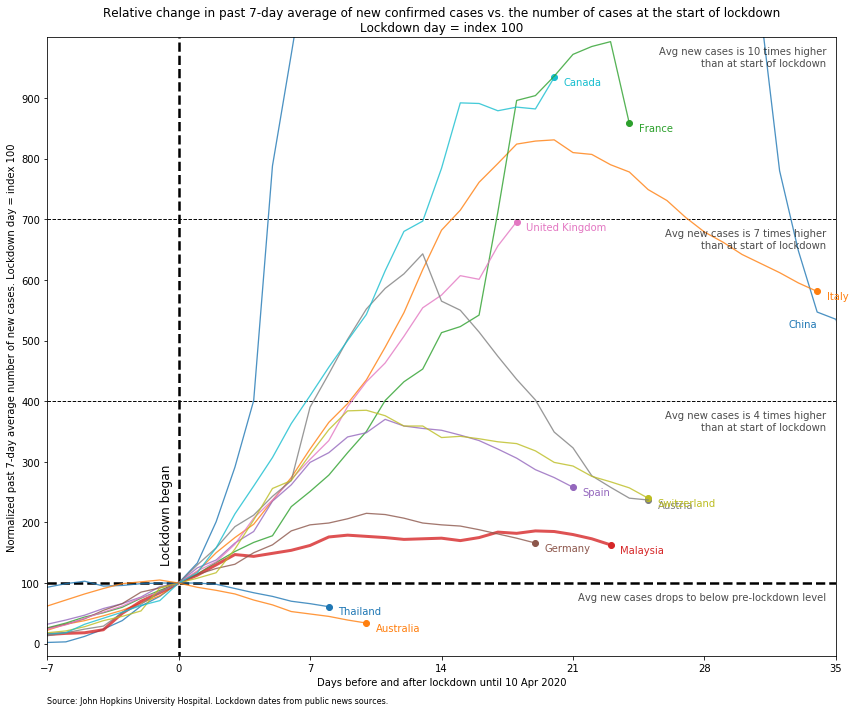

In [52]:
countries = ['China', 'Italy', 'France', 'Malaysia', 'Spain', 'Germany', 'United Kingdom',
             'Austria', 'Switzerland', 'Canada', 'Thailand', 'Australia']
fig, ax = plt.subplots(figsize=(12,10))
xmax=7*5
for c, country in enumerate(countries):
    lockstart = pd.to_datetime(lockdates[country]['start'])
    data = df1a[df1a.country==country].reset_index()
    data['dminus'] = data.date.apply(lambda row: (row - lockstart).days)
    data = data.sort_values('date')
    data['new_conf_avg_7'] = data.new_confirmed.rolling(window=7).mean()
    dayzero = data[data.date==lockstart].new_conf_avg_7
    data['new_conf_index'] = round(data.new_conf_avg_7.apply(lambda row: row/dayzero*100))
    data = data.set_index('date')
    color = f'C{c}' if c < 10 else f'C{str(c)[-1]}'
    lw = 3 if country=='Malaysia' else 1.3
    measure = 'new_conf_index'
    plt.plot(data.dminus, data[measure], label=country, color=color, alpha=0.8, lw=lw)
    plt.scatter(data.dminus.max(), data[measure][-1], color=color)
    xpos = xmax-1 if country=='China' else data.dminus.max()+0.5
    ypos = data[data.dminus==xmax][measure] if country=='China' else data[measure][-1]
    xha = 'right' if country=='China' else 'left'
    plt.text(xpos, ypos, country, color=color, va='top', ha=xha)
plt.vlines(0,-50,1000, linewidth=2.5, linestyle='--')
plt.text(-1,130,'Lockdown began', rotation=90, va='bottom', fontsize=12)
plt.text(xmax-0.5, 985, 'Avg new cases is 10 times higher\nthan at start of lockdown', ha='right', va='top', alpha=0.7)
plt.hlines(700,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 685, 'Avg new cases is 7 times higher\nthan at start of lockdown', ha='right', va='top', alpha=0.7)
plt.hlines(400,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 385, 'Avg new cases is 4 times higher\nthan at start of lockdown', ha='right', va='top', alpha=0.7)
plt.hlines(100,-7,xmax, linewidth=2.5, linestyle='--')
plt.text(xmax-0.5, 85, 'Avg new cases drops to below pre-lockdown level', ha='right', va='top', alpha=0.7)
ax.set_ylim(-20, 1000)
ax.set_xlim(-7,xmax)
ax.set_xticks(range(-7,xmax+1,7))
ax.set_yticks(range(0,1000,100))
ax.set_ylabel('Normalized past 7-day average number of new cases. Lockdown day = index 100')
ax.set_xlabel(f'Days before and after lockdown until {date.day} {mdict[date.month]} 2020')
ax.set_title('Relative change in past 7-day average of new confirmed cases vs. the number of cases at the start of lockdown\nLockdown day = index 100')
source='John Hopkins University Hospital.'
footnote='Lockdown dates from public news sources.'
plt.annotate(f'Source: {source} {footnote}',
             (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/lockdown_msia_post_lockdown_2", pad_inches=0)
plt.show()

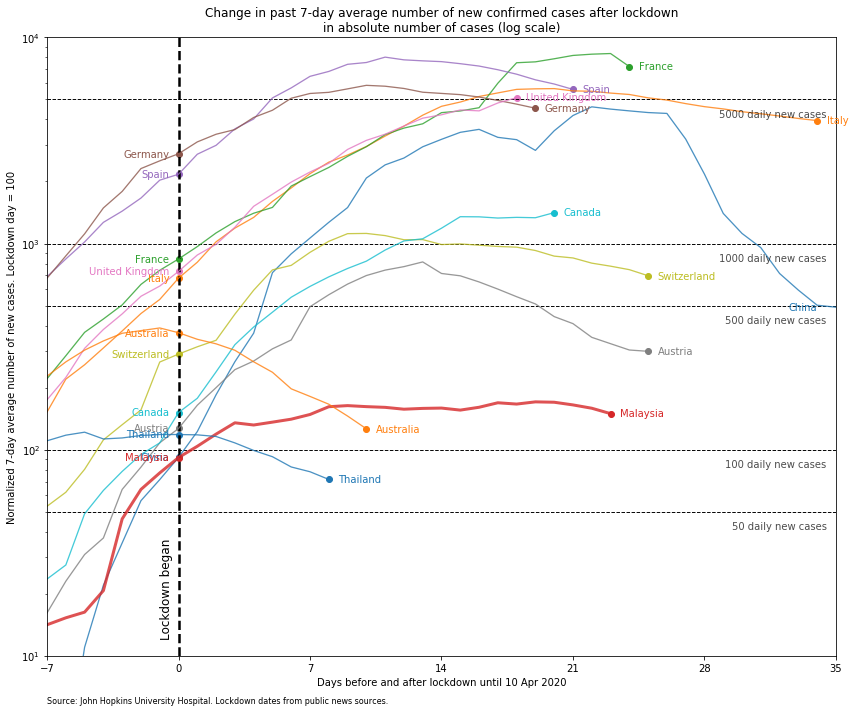

In [53]:
countries = ['China', 'Italy', 'France', 'Malaysia', 'Spain', 'Germany', 'United Kingdom',
             'Austria', 'Switzerland', 'Canada', 'Thailand', 'Australia']
fig, ax = plt.subplots(figsize=(12,10))
xmax=7*5
for c, country in enumerate(countries):
    lockstart = pd.to_datetime(lockdates[country]['start'])
    data = df1a[df1a.country==country].reset_index()
    data['dminus'] = data.date.apply(lambda row: (row - lockstart).days)
    data = data.sort_values('date')
    data['new_conf_avg_7'] = data.new_confirmed.rolling(window=7).mean()
    dayzero = data[data.date==lockstart].new_conf_avg_7
    data['new_conf_index'] = round(data.new_conf_avg_7.apply(lambda row: row/dayzero*100))
    data = data.set_index('date')
    color = f'C{c}' if c < 10 else f'C{str(c)[-1]}'
    lw = 3 if country=='Malaysia' else 1.3
    measure = 'new_conf_avg_7'
    plt.plot(data.dminus, data[measure], label=country, color=color, alpha=0.8, lw=lw)
    plt.scatter(data.dminus.max(), data[measure][-1], color=color)
    plt.scatter(0, data[data.dminus==0][measure], color=color)
    plt.text(-0.5, data[data.dminus==0][measure], country, color=color, va='center', ha='right')
    xpos = xmax-1 if country=='China' else data.dminus.max()+0.5
    ypos = data[data.dminus==xmax][measure] if country=='China' else data[measure][-1]
    xha = 'right' if country=='China' else 'left'
    plt.text(xpos, ypos, country, color=color, va='center', ha=xha)
plt.vlines(0, 10, 5e4, linewidth=2.5, linestyle='--')
plt.text(-1,12,'Lockdown began', rotation=90, va='bottom', fontsize=12)

plt.hlines(0.5e4,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 0.5e4-0.5e3, '5000 daily new cases', ha='right', va='top', alpha=0.7)
plt.hlines(1.0e3,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 1.0e3-1.0e2, '1000 daily new cases', ha='right', va='top', alpha=0.7)
plt.hlines(0.5e3,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 0.5e3-0.5e2, '500 daily new cases', ha='right', va='top', alpha=0.7)
plt.hlines(1.0e2,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 1.0e2-1.0e1, '100 daily new cases', ha='right', va='top', alpha=0.7)
plt.hlines(0.5e2,-7,xmax, linewidth=0.95, linestyle='--')
plt.text(xmax-0.5, 0.5e2-0.5e1, '50 daily new cases', ha='right', va='top', alpha=0.7)

ax.set_ylim(10, 1e4)
ax.set_xlim(-7,xmax)
ax.set_xticks(range(-7,xmax+1,7))
ax.set_ylabel('Normalized 7-day average number of new cases. Lockdown day = 100')
ax.set_xlabel(f'Days before and after lockdown until {date.day} {mdict[date.month]} 2020')
ax.set_title('Change in past 7-day average number of new confirmed cases after lockdown\nin absolute number of cases (log scale)')
plt.yscale('log')
source='John Hopkins University Hospital.'
footnote='Lockdown dates from public news sources.'
plt.annotate(f'Source: {source} {footnote}',
             (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/lockdown_msia_post_lockdown_3", pad_inches=0)
plt.show()

In [54]:
asiapac = ['Malaysia', 'Australia', 'Brunei', 'China', 'Hong Kong', 'Indonesia', 'Japan', 'South Korea', 'Laos', 'Macao',
           'Myanmar', 'Mongolia', 'New Zealand', 'Philippines', 'Singapore','Thailand', 'Vietnam', 'Taiwan']

west = ['Malaysia', 'Austria', 'Belgium', 'Canada', 'Switzerland', 'Germany', 'Denmark', 'Spain', 'Finland', 'France',
        'United Kingdom', 'Ireland', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Sweden', 'United States']

In [55]:
cols_std = ['tracing', 'testing', 'movement', 'immigration', 'school',
            'workplace', 'events', 'transport', 'campaigns']
maxpoints = {'school':2, 'workplace':2, 'events':2, 'transport':2, 'campaigns':1,
             'movement':2, 'immigration':3, 'testing':3, 'tracing':2}
oxford2 = oxford.copy()
for col in cols_std:
    oxford2[f'{col}2'] = oxford2[col].apply(lambda row: row/maxpoints[col])
oxford2 = oxford2.loc[latestdate].sort_values(by=['stringency','tracing','testing'], ascending=False)
showcols = [0,15,16,17,18,19,20,21,22]
oxford3 = oxford2.iloc[:,showcols].set_index('country', drop=True)

xlabels = ['Tracing policy', 'Testing policy', 'Movement restrictions', 'Immigration controls',
           'School closed', 'Workplace closed', 'Public events cancelled', 'Public transport closed']
annot = f'Source: Oxford COVID-19 Government Response Tracker.\nScores normalized between 0 (lowest) and 1 (highest).\nUpdated {date.day} {mdict[date.month]} 2020'

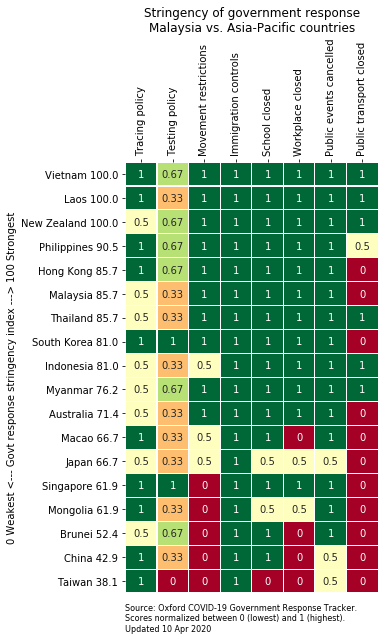

In [56]:
region = asiapac
fig, ax = plt.subplots(figsize=(5.5,9))
temp = oxford2[oxford2.country.isin(region)][['country','stringency']]
temp['ylabel'] = temp.apply(lambda row: f'{row.country} {round(row.stringency,1)}', axis=1)

sns.heatmap(oxford3.loc[oxford3.index.isin(region)], annot=True, linewidths=.1,
            xticklabels=xlabels, yticklabels=temp.ylabel.values, cmap='RdYlGn', cbar=False)

ax.set_title('Stringency of government response\nMalaysia vs. Asia-Pacific countries')
ax.set_ylabel('0 Weakest <--- Govt response stringency index ---> 100 Strongest')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)
plt.annotate(annot, (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/stringency_msia_rank_asiapac", pad_inches=0)
plt.show()

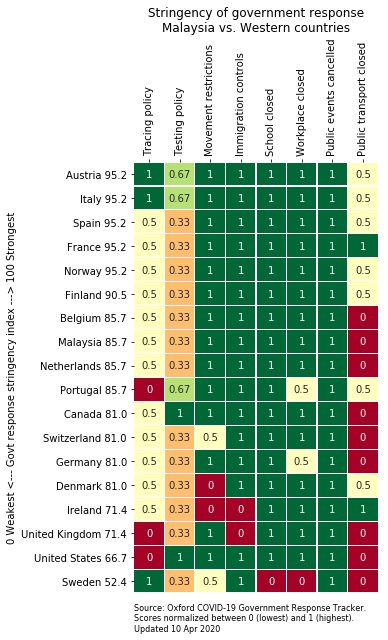

In [57]:
region = west
fig, ax = plt.subplots(figsize=(5.5,9))
temp = oxford2[oxford2.country.isin(region)][['country','stringency']]
temp['ylabel'] = temp.apply(lambda row: f'{row.country} {round(row.stringency,1)}', axis=1)

sns.heatmap(oxford3.loc[oxford3.index.isin(region)], annot=True, linewidths=.1,
            xticklabels=xlabels, yticklabels=temp.ylabel.values, cmap='RdYlGn', cbar=False)
ax.set_title('Stringency of government response\nMalaysia vs. Western countries')
ax.set_ylabel('0 Weakest <--- Govt response stringency index ---> 100 Strongest')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)
plt.annotate(annot, (0,0), (0, -10), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/stringency_msia_rank_west", pad_inches=0)
plt.show()

### 5. Are countries testing enough?

In [58]:
pop = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population', header=0, index_col=0)[0].iloc[:,:2]
pop.columns = ['country','pop']
pop.country = pop.country.apply(lambda row: row[:row.find("[")] if row.find("[")!=-1 else row)
pop = pop.set_index('country')
pop.to_csv('dfdata/population.csv')
ccodes = pd.read_csv('dfdata/countrycode.csv', encoding='latin-1', index_col=0)

In [59]:
pop = pd.read_csv('dfdata/population.csv', index_col=0)
latestdate0 = df1.index.max()
df5 = testnum.loc[latestdate0]
df5 = df5.join(ccodes, on='country')
df5 = df5.join(df1.loc[latestdate0][['country','confirmed','deaths']].set_index('country'), on='country').set_index('country')
df5 = df5.join(pop)

In [76]:
df5

,tested,ccode2,ccode3,confirmed,deaths,pop,test_per_pop,conf_per_pop,death_per_pop,conf_per_test,death_per_test
country,,,,,,,,,,,
Australia,338346.0,AU,AUS,6215,54,25674594,13.178241,0.242068,0.002103,0.018369,0.000160
Austria,134743.0,AT,AUT,13555,319,8902600,15.135241,1.522589,0.035832,0.100599,0.002367
Bahrain,57307.0,BH,BHR,925,6,1543300,37.132767,0.599365,0.003888,0.016141,0.000105
Belgium,96636.0,BE,BEL,26667,3019,11524454,8.385300,2.313949,0.261965,0.275953,0.031241
Canada,375302.0,CA,CAN,22059,557,37989621,9.879067,0.580659,0.014662,0.058777,0.001484
Costa Rica,6226.0,CR,CRI,558,3,5058007,1.230920,0.110320,0.000593,0.089624,0.000482
Czech Republic,114854.0,CZ,CZE,5732,119,10693939,10.740102,0.536005,0.011128,0.049907,0.001036
Denmark,64731.0,DK,DNK,5830,247,5822763,11.116887,1.001243,0.042420,0.090065,0.003816
Ecuador,21568.0,EC,ECU,7161,297,17462808,1.235082,0.410072,0.017008,0.332020,0.013770


In [78]:
df5['test_per_pop'] = df5['tested']/df5['pop']*1000
df5['conf_per_pop'] = df5['confirmed']/df5['pop']*1000
df5['death_per_pop'] = df5['deaths']/df5['pop']*1000
df5['conf_per_test'] = df5['confirmed']/df5['tested']
df5['death_per_test'] = df5['deaths']/df5['tested']

from sklearn.linear_model import LinearRegression
def reg_line (m, c, xs):
    return [(m*x)+c for x in xs]

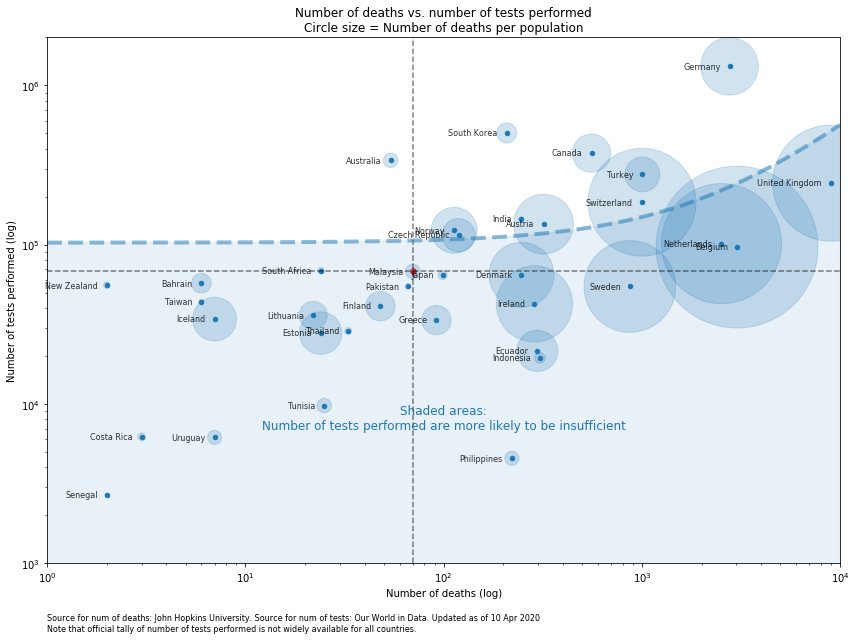

In [285]:
mindeath, maxdeath = 1, 1e4
mintest, maxtest = 1e3, 2e6
minfit, maxfit = 1, 1e4
fitdata = df5[(df5.deaths>minfit) & (df5.deaths<maxfit)]
linreg = LinearRegression(fit_intercept=True)
linreg.fit(np.array(fitdata.deaths).reshape(-1, 1), np.array(fitdata.tested).reshape(-1, 1))
c = linreg.intercept_[0]
m = linreg.coef_[0][0]

data = df5[(df5.deaths>mindeath) & (df5.deaths<maxdeath)]
fig, ax = plt.subplots(figsize=(12,9))
plt.scatter(data.deaths, data.tested, alpha=0.2, s=data.death_per_pop*1e5, c='C0')
plt.scatter(data.deaths, data.tested, s=20, c='C0')
for i in range(len(data)):
    plt.text(data.deaths.iloc[i]*0.9, data.tested.iloc[i], data.index[i],
             va='center', ha='right', fontsize=8, alpha=0.8)
plt.scatter(data.deaths.loc['Malaysia'], data.tested.loc['Malaysia'], s=30, alpha=1, c='C3')

xplot = np.linspace(minfit,maxfit,maxfit)
plt.plot(xplot, reg_line(m, c, xplot), alpha=0.5, linestyle='dashed', linewidth=4)
plt.fill_between(xplot, reg_line(m, c, xplot), alpha=0.1, color='C0')
plt.text(1e2, 0.7e4, 'Shaded areas:\nNumber of tests performed are more likely to be insufficient', ha='center', color='C0', fontsize=12)

plt.vlines(data.deaths.loc['Malaysia'], mintest, maxtest, linestyle='dashed', alpha=0.5)
plt.hlines(data.tested.loc['Malaysia'], mindeath, maxdeath, linestyle='dashed', alpha=0.5)
plt.ylabel('Number of tests performed (log)')
plt.xlabel('Number of deaths (log)')
ax.set_title('Number of deaths vs. number of tests performed\nCircle size = Number of deaths per population')
plt.xscale('log')
plt.yscale('log')
ax.set_xlim(mindeath, maxdeath)
ax.set_ylim(mintest, maxtest)
plt.annotate(f'Source for num of deaths: John Hopkins University. Source for num of tests: Our World in Data. Updated as of {latestdate}\nNote that official tally of number of tests performed is not widely available for all countries.', (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/test_vs_deaths_msia", pad_inches=0)
plt.show()

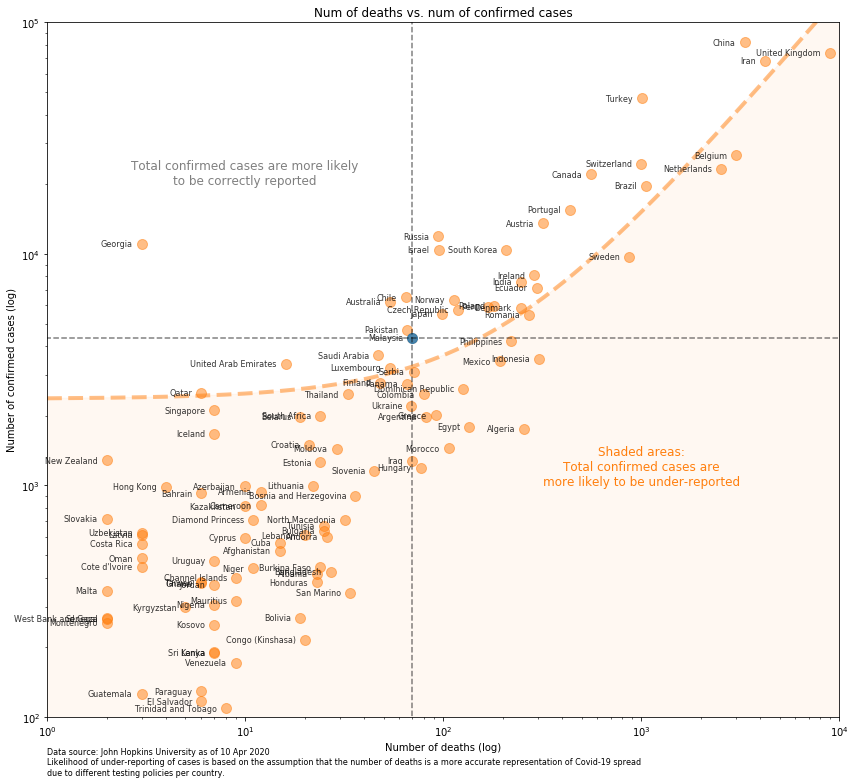

In [287]:
mindeath, maxdeath = 1, 1e4
minconfirmed, maxconfirmed = 100, 1e5
fitdata = df1[(df1.deaths>mindeath) & (df1.deaths<maxdeath)].loc[latestdate0].join(ccodes, on='country')
linreg = LinearRegression(fit_intercept=True)
linreg.fit(np.array(fitdata.deaths).reshape(-1, 1), np.array(fitdata.confirmed).reshape(-1, 1))
c = linreg.intercept_[0]
m = linreg.coef_[0][0]

data = df1[(df1.deaths>mindeath) & (df1.confirmed>minconfirmed) &
           (df1.confirmed<maxconfirmed)].loc[latestdate0].join(ccodes, on='country')
fig, ax = plt.subplots(figsize=(12,11))
plt.scatter(data.deaths, data.confirmed, s=100, alpha=0.5, c='C1')
for i in range(len(data)):
    plt.text(data.deaths.iloc[i]*0.9, data.confirmed.iloc[i], data.country.iloc[i],
             va='center', ha='right', fontsize=8, alpha=0.8)
msia = data.country=='Malaysia'
plt.scatter(data.deaths[msia], data.confirmed[msia], s=100, alpha=0.8, c='C0')

xplot = np.linspace(mindeath,maxdeath,maxdeath)
plt.plot(xplot, reg_line(m, c, xplot), c='C1', alpha=0.5, linestyle='dashed', linewidth=4)
plt.fill_between(xplot, reg_line(m, c, xplot), alpha=0.05, color='C1')
plt.text(1e3, 1e3, 'Shaded areas:\nTotal confirmed cases are\nmore likely to be under-reported', ha='center', color='C1', fontsize=12)
plt.text(1e1, 2e4, 'Total confirmed cases are more likely\nto be correctly reported', ha='center', color='black', fontsize=12, alpha=0.5)

plt.vlines(data.deaths[msia], 0, maxconfirmed, linestyle='dashed', alpha=0.5)
plt.hlines(data.confirmed[msia], 0, maxdeath, linestyle='dashed', alpha=0.5)
plt.xlabel('Number of deaths (log)')
plt.ylabel('Number of confirmed cases (log)')
ax.set_title('Num of deaths vs. num of confirmed cases')
plt.xlim(mindeath, maxdeath)
plt.ylim(minconfirmed, maxconfirmed)
plt.xscale('log')
plt.yscale('log')
plt.annotate(f'Data source: John Hopkins University as of {latestdate}\nLikelihood of under-reporting of cases is based on the assumption that the number of deaths is a more accurate representation of Covid-19 spread\ndue to different testing policies per country.', (0,0), (0, -30), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=8)
plt.tight_layout()
plt.savefig(f"img/death_vs_confirmed_msia", pad_inches=0)
plt.show()


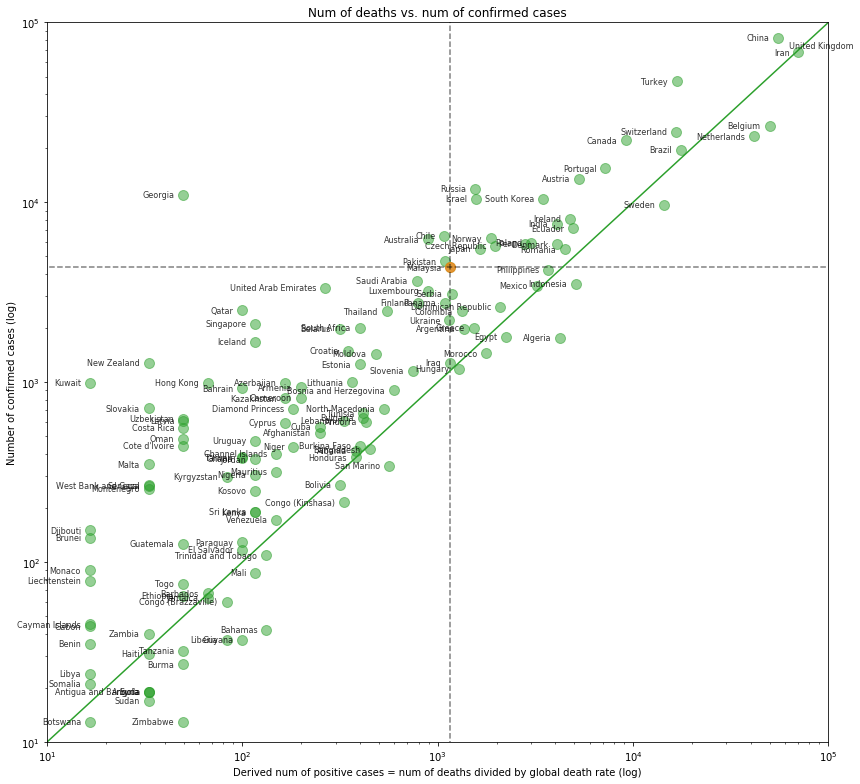

In [263]:
minconfirmed, maxconfirmed   = 10, 1e5
minconfirmed2, maxconfirmed2 = 10, 1e5
data0 = df1[df1.deaths>0].loc[latestdate0]
drate = data0.deaths.sum()/data0.confirmed.sum()
data = df1[(df1.deaths>0) & (df1.confirmed>minconfirmed) & (df1.confirmed<maxconfirmed2)].loc[latestdate0][['country','confirmed','deaths']]
data['confirmed2'] = data.deaths/drate

fig, ax = plt.subplots(figsize=(12,11))
plt.scatter(data.confirmed2, data.confirmed, s=100, alpha=0.5, c='C2')
for i in range(len(data)):
    plt.text(data.iloc[i].confirmed2*0.9, data.iloc[i].confirmed, data.iloc[i].country,
             va='center', ha='right', fontsize=8, alpha=0.8)
    
xplot = np.linspace(0,3e5,1e3)
plt.plot(xplot, xplot, c='C2')

msia = data.country=='Malaysia'
plt.scatter(data.confirmed2[msia], data.confirmed[msia], s=100, alpha=0.7, c='C1')
plt.hlines(data.confirmed[msia], 0, maxconfirmed2, linestyle='dashed', alpha=0.5)
plt.vlines(data.confirmed2[msia], 0, maxconfirmed, linestyle='dashed', alpha=0.5)

plt.xlabel('Derived num of positive cases = num of deaths divided by global death rate (log)')
plt.ylabel('Number of confirmed cases (log)')
ax.set_title('Num of deaths vs. num of confirmed cases')
ax.set_ylim(minconfirmed, maxconfirmed)
ax.set_xlim(minconfirmed2, maxconfirmed2)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig(f"img/confirmed_estimate_msia", pad_inches=0)
plt.show()
